<a href="https://colab.research.google.com/github/newstage75/ML_local_study/blob/master/zero_deep_learning_study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ゼロから作るDeep Learning 3 勉強用 Notebook

書籍と[書籍の公式リポジトリ](https://github.com/oreilly-japan/deep-learning-from-scratch-3)を参考にGoogle Colabで手を動かしながら学習します。


本Notebookに使用されるコードのライセンスは、上記リポジトリのライセンスに従います。以下ラインセンスへのリンクです。

[LICENSE](https://github.com/oreilly-japan/deep-learning-from-scratch-3/blob/master/LICENSE.md)

## 事前準備

必要なライブラリのインポート（Stage 1〜 Stage3）

In [ ]:
import numpy as np
import weakref
import contextlib

必要なライブラリのインポート（Stage 3）

In [ ]:
from graphviz import Digraph
from IPython.display import Image as IPImage
from IPython.display import display_png

DeZeroのダウンロード （Step23〜）

In [ ]:
!cd /content
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-3
%cd /content/deep-learning-from-scratch-3

Cloning into 'deep-learning-from-scratch-3'...
remote: Enumerating objects: 1865, done.
remote: Total 1865 (delta 0), reused 0 (delta 0), pack-reused 1865
Receiving objects: 100% (1865/1865), 14.13 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (1316/1316), done.
/content/deep-learning-from-scratch-3


is_simple_core の切り替え`is_simple_core = True`（Step23〜Step32のみ実施）

In [ ]:
!sed -e "s/is_simple_core = False/is_simple_core = True/" ./dezero/__init__.py > tmp.py
!mv tmp.py ./dezero/__init__.py

In [ ]:
!head ./dezero/__init__.py

# =============================================================================
# step23.pyからstep32.pyまではsimple_coreを利用
is_simple_core = True  # True
# =============================================================================

if is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import Function
    from dezero.core_simple import using_config
    from dezero.core_simple import no_grad


## Stage 1 微分を自動で求める


### Step 1 箱としての変数

#### 1.1 変数とは

略（本を参照）


#### 1.2 Variableクラスの実装

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data

In [ ]:
import numpy as np

data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


In [ ]:
x.data = np.array(2.0)
print(x.data)

2.0


#### 1.3 【補足】NumPyの多次元配列

`ndim` は多次元配列の「次元の数」を意味します。

In [ ]:
import numpy as np
x = np.array(1)
x.ndim

0

In [ ]:
x = np.array([1, 2, 3])
x.ndim

1

In [ ]:
x = np.array([[1, 2, 3],
                    [4, 5, 6]])
x.ndim

2

### Step 2 変数を生み出す関数

#### 2.1 関数とは

#### 2.2 Functionクラスの実装

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = x ** 2
    output = Variable(y)
    return output

#### Functionクラスを使う

In [ ]:
x = Variable(np.array(10))
f = Function()
y = f(x)

print(type(y))
print(y.data)

<class '__main__.Variable'>
100


`Function`クラスを基底クラスとして作り変えます。

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    return output

  def forward(self, x ):
    raise NotImplementedError()

In [ ]:
class Square(Function):
  def forward(self, x):
    return x ** 2

In [ ]:
x = Variable(np.array(10))
f = Square()
y = f(x)
print(type(y))
print(y.data)

<class '__main__.Variable'>
100


### Step 3 関数の連結

#### 3.1 Exp関数の実装

In [ ]:
class Exp(Function):
  def forward(self, x):
    return np.exp(x)

#### 3.2 関数を連結する

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
print(y.data)

1.648721270700128


### Step 4 数値微分

#### 4.1 微分とは

#### 4.2 数値微分の実装

In [ ]:
def numerical_diff(f, x, eps=1e-4):
  x0 = Variable(x.data -eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

In [ ]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy)

4.000000000004


#### 4.3 合成関数の微分

In [ ]:
def f(x):
  A = Square()
  B = Exp()
  C = Square()
  return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)

3.2974426293330694


#### 4.4 数値微分の問題点

- 数値部分は誤差が大きい
- 代わりとなるのがバックプロパゲーション
- バックプロバゲーションの実装の正しさに数値微分の結果を使う（勾配確認と呼ばれる）



### Step 5 バックプロパゲーションの理論

#### 5.1 チェインルール




$\frac{dy}{dx} = \frac{dy}{db} \frac{db}{da} \frac{da}{dx}$

#### 5.2 バックプロパゲーションの導出


$\frac{dy}{dx} = ((\frac{dy}{dy}\frac{dy}{db}) \frac{db}{da}) \frac{da}{dx}$

#### 5.3 計算グラフで表す

### Step 6 手作業によるバックプロパゲーション

#### 6.1 Variableクラスの追加実装

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None

#### 6.2 Functionクラスの追加実装

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    self.input = input
    return output

  def forward(self, x ):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

#### 6.3 SquareとExpクラスの追加実装

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx

In [ ]:
class Exp(Function):
  def forward(self, x):
    y = np.exp(x)
    return y

  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

#### 6.4 バックプロパゲーションの実装

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [ ]:
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


### Step 7バックプロパゲーションの自動化

#### 7.1 逆伝播の自動化のために

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x ):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

Functionを定義し直したので、SquareとExpを再定義

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx

In [ ]:
class Exp(Function):
  def forward(self, x):
    y = np.exp(x)
    return y

  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

#### 7.2 逆伝播を試す

In [ ]:
y.grad = np.array(1.0)

C = y.creator
b = C.input
b.grad = C.backward(y.grad)

In [ ]:
B = b.creator
a = B.input
a.grad = B.backward(b.grad)

In [ ]:
A = a.creator
x = A.input
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


#### 7.3 backwardメソッドの追加

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    f = self.creator
    if f is not None:
      x = f.input
      x.grad = f.backward(self.grad)
      x.backward()

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


### Step 8 再帰からループへ

#### 8.1 現時点のVariableクラス

以下は再帰を使った実装です。

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    f = self.creator
    if f is not None:
      x = f.input
      x.grad = f.backward(self.grad)
      x.backward()

#### 8.2 ループを使った実装

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)
 
      if x.creator is not None:
        funcs.append(x.creator)

#### 8.3 動作確認

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


### Step9 関数をより便利に

#### 9.1 Pythonの関数として利用

In [ ]:
x = Variable(np.array(0.5))
f = Square()
y = f(x)

いちいちインスタンスを生成するのは手間なので。以下のように書きます。

In [ ]:
def square(x):
  f = Square()
  return f(x)

def exp(x):
  f = Exp()
  return f(x)

さらに以下のようにも書ける

In [ ]:
def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

実装した2つの関数で書き直します。

In [ ]:
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)


y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


関数を連続して適用する書き方です。

In [ ]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


#### 9.2 backwardメソッドの簡略化

In [ ]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)
 
      if x.creator is not None:
        funcs.append(x.creator)

In [ ]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.backward()
print(x.grad)

3.297442541400256


#### 9.3 ndarrayだけを扱う

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)
 
      if x.creator is not None:
        funcs.append(x.creator)

In [ ]:
x = Variable(np.array(1.0))
x = Variable(None)

x = Variable(1.0)

TypeError: ignored

In [ ]:
x = np.array([1.0])
y = x ** 2
print(type(x), x.ndim)
print(type(y))

<class 'numpy.ndarray'> 1
<class 'numpy.ndarray'>


In [ ]:
x = np.array(1.0)
y = x ** 2
print(type(x), x.ndim)
print(type(y))

<class 'numpy.ndarray'> 0
<class 'numpy.float64'>


In [ ]:
def as_array(x):
  if np.isscalar(x):
    return np.array(x)
  return x

In [ ]:
np.isscalar(np.float64(1.0))

True

In [ ]:
np.isscalar(2.0)

True

In [ ]:
np.isscalar(np.array(1.0))

False

In [ ]:
np.isscalar(np.array([1, 2, 3]))

False

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(as_array(y))
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x ):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

### Step 10 テストを行う

#### 10.1 Pythonのユニットテスト

In [ ]:
import unittest

class SquareTest(unittest.TestCase):
  def test_forward(self):
    x = Variable(np.array(2.0))
    y = square(x)
    expected = np.array(4.0)
    print(y.data)
    print(expected)
    self.assertEqual(y.data, expected)

#### 10.2 square関数の逆伝播のテスト

In [ ]:
class SquareTest(unittest.TestCase):
  def test_forward(self):
    x = Variable(np.array(2.0))
    y = square(x)
    expected = np.array(4.0)
    print(y.data)
    print(expected)
    self.assertEqual(y.data, expected)

  def test_backward(self):
    x = Variable(np.array(3.0))
    y = square(x)
    y.backward()
    expected = np.array(6.0)
    self.assertEqual(x.grad, expected)

#### 10.3 勾配確認による自動テスト

In [ ]:
def numerical_diff(f, x, eps=1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)


class SquareTest(unittest.TestCase):
  def test_forward(self):
    x = Variable(np.array(2.0))
    y = square(x)
    expected = np.array(4.0)
    print(y.data)
    print(expected)
    self.assertEqual(y.data, expected)

  def test_backward(self):
    x = Variable(np.array(3.0))
    y = square(x)
    y.backward()
    expected = np.array(6.0)
    self.assertEqual(x.grad, expected)

  def test_gradient_check(self):
    x = Variable(np.random.rand(1))
    y = square(x)
    y.backward()
    num_grad = numerical_diff(square, x)
    flg = np.allclose(x.grad, num_grad)
    self.assertTrue(flg)

`np.allclose` で値の近さが一定値以下かを判定できます。

$ | a - b | <= (atol + rtol * |b|)$

#### 10.4 テストについてのまとめ

テストは本家リポジトリのソフトを使って実行

In [ ]:
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/steps/step10.py

--2020-05-10 10:58:07--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/steps/step10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2200 (2.1K) [text/plain]
Saving to: ‘step10.py’

step10.py           100%[===================>]   2.15K  --.-KB/s    in 0s      

2020-05-10 10:58:07 (47.8 MB/s) - ‘step10.py’ saved [2200/2200]



In [ ]:
!python -m unittest step10.py

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


### コラム： 自動微分

微分を求める方法は大きく3つあります。

1. 数値微分：微小な差異から近似的に計算
1. 数式微分：微分の公式を用いる
1. 自動微分:チェインルールを使う

自動微分は、以下の2つに分けられます。

1. forwardモード
1. reverseモード

バックプロパゲーションは、reverseモードの自動微分です。

## Stage 2 自然なコードで表現する

### Step 11 可変長の引数（順伝播編）

最初に Numpyをインポート

In [ ]:
import numpy as np

#### 11.1 Functionクラスの修正

現状の`Function`クラスです。

In [ ]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(as_array(y))
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x ):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

修正した`Function`クラス（複数の入出力に対応）です。

In [ ]:
class Function:
  def __call__(self, inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(xs)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs
    return outputs

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

再度 Variableクラスを定義

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)
 
      if x.creator is not None:
        funcs.append(x.creator)

再度 as_array(x) 関数を定義

In [ ]:
def as_array(x):
  if np.isscalar(x):
    return np.array(x)
  return x

#### 11.2 Addクラスの実装

In [ ]:
class Add(Function):
  def forward(self, xs):
    x0, x1 = xs
    y = x0 + x1
    return (y,)

In [ ]:
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)

5


### Step 12 可変長の引数（改善編）

#### 12.1 1つめの改善：関数を使いやすく

修正したFunctionクラス

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(xs)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

可変長引数：
- リストを使わずに任意の数の引数を与えて関数を呼べる
- 関数を定義するときの引数にアスタリスクを付けて使う

挙動は以下の通り

In [ ]:
def f(*x):
  print(x)

In [ ]:
f(1,2,3)

(1, 2, 3)


In [ ]:
f(1,2,3,4,5,6)

(1, 2, 3, 4, 5, 6)


Addクラスを再定義して以下実行

In [ ]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))

f = Add()
y = f(x0, x1)
print(y.data)

5


#### 12.2 2つ目の改善：関数を実装しやすく

修正したFunctionクラス

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

修正したAddクラス

In [ ]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

#### 12.3 add関数の実装

In [ ]:
def add(x0, x1):
  return Add()(x0, x1)

In [ ]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


### Step 13 可変長の引数（逆伝播編）

#### 13.1 可変長引数に対応したAddクラスの逆伝播

In [ ]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    return gy, gy

#### 13.2 Variableクラスの修正

現状のVariableクラスの実装

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)
 
      if x.creator is not None:
        funcs.append(x.creator)

修正したVariableクラスの実装

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        x.grad = gx

        if x.creator is not None:
          funcs.append(x.creator)

#### 13.3 Squareクラスの実装

修正前のSquareクラス

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx

修正後のSquareクラス

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = 2 * x * gy
    return gx

square関数を定義

In [ ]:
def square(x):
  return Square()(x)

In [ ]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


### Step 14 同じ変数を繰り返し使う

同じ変数を使って足算を使うと、`x.grad`の結果が本来は`2`になって欲しいところが`1`になってしまいます。

In [ ]:
x = Variable(np.array(3.0))
y = add(x, x)
print('y', y.data)

y.backward()
print('x.grad', x.grad)

y 6.0
x.grad 1.0


#### 14.1 問題の原因

Variableクラスの確認

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        x.grad = gx  # ここが間違い

        if x.creator is not None:
          funcs.append(x.creator)

`x.grad = gx` が間違いです。同じ変数を繰り返し使って計算した場合、値が上書きされてしまいます。

#### 14.2 解決策

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          funcs.append(x.creator)

`x.grad = x.grad + gx` を `x.grad += gx` としない理由は付録Aで補足します。

もう一度計算を行う

In [ ]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print('x.grad', x.grad)

x.grad 2.0


In [ ]:
x = Variable(np.array(3.0))
y = add(add(x, x), x)
y.backward()
print('x.grad', x.grad)

x.grad 3.0


#### 14.3 微分をリセットする

14.2の修正で新たな問題が出てきます。同じ変数を使って、別の計算を行う場合です。

In [ ]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print('x.grad', x.grad)

y = add(add(x, x), x)
y.backward()
print('x.grad', x.grad)

x.grad 2.0
x.grad 5.0


微分が `3`ではなく`5`になってしまいます。

`Variable`クラスに`cleargrad`という微分を初期化するメソッドを追加します。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          funcs.append(x.creator)

  def cleargrad(self):
    self.grad = None

`cleargrad`メソッドを使って再度計算します。

In [ ]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print('x.grad', x.grad)

x.cleargrad()
y = add(add(x, x), x)
y.backward()
print('x.grad', x.grad)


x.grad 2.0
x.grad 3.0


`cleargrad`メソッドは Step 28でも使用

### 付録 A インプレース演算（Step 14の補足）

#### A.1 問題の確認

Variableをインプレース演算で書き換えます（インプレース演算の説明は次で実施します）。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad += gx

        if x.creator is not None:
          funcs.append(x.creator)

  def cleargrad(self):
    self.grad = None

#### A.2 コピーと上書きについて

インスタンスの「コピー」と「上書き」を知ります。

In [ ]:
import numpy as np
x = np.array(1)
id(x)

140197672225488

上書き

In [ ]:
x += x
id(x)

140197672225488

コピー

In [ ]:
x = x + x
id(x)

140197674711296

xのオブジェクトIDが変わらないと、メモリ位置が同じであることを意味します。

コピーを行わずにメモリの値を直接上書きする演算はインプレース演算（in-place 演算）と呼ばれます

#### A.3 DeZero の逆伝播では

In [ ]:
x = Variable(np.array(3))
y = add(x, x)
y.backward()


print('y.grad: {}({})'.format(y.grad, id(y.grad)))
print('x.grad: {}({})'.format(x.grad, id(x.grad)))

y.grad: 2(140197672210880)
x.grad: 2(140197672210880)


インプレース演算だと誤った計算となります。

Variableを修正

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          funcs.append(x.creator)

  def cleargrad(self):
    self.grad = None

In [ ]:
x = Variable(np.array(3))
y = add(x, x)
y.backward()


print('y.grad: {}({})'.format(y.grad, id(y.grad)))
print('x.grad: {}({})'.format(x.grad, id(x.grad)))

y.grad: 1(140197672275040)
x.grad: 2(140197674711344)


### Step 15 複雑な計算グラフ（理論編）

#### 15.1 逆伝播の正しい順番

#### 15.2 現状の DeZero

現状の`Variable`クラスです。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop() # ここに注目
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          funcs.append(x.creator) # ここに注目

  def cleargrad(self):
    self.grad = None

#### 15.3 関数の優先度

### Step 16 複雑な計算グラフ（実装編）

#### 16.1 世代の追加

`Variable`クラスに`generation`を追加します。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0 # 追加

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1 # 追加

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          funcs.append(x.creator)

  def cleargrad(self):
    self.grad = None

`Function`クラスに`generation`を追加します。

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    self.generation = max([x.generation for x in inputs])
    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

#### 16.2 世代順に取り出す

ダミーの関数を用意してfuncsというリストに追加します。

In [ ]:
generations = [2, 0, 1, 4, 2]
funcs = []

for g in generations:
  f = Function()
  f.generation = g
  funcs.append(f)

[f.generation for f in funcs]

[2, 0, 1, 4, 2]

In [ ]:
funcs.sort(key=lambda x: x.generation)
[f.generation for f in funcs]

[0, 1, 2, 2, 4]

In [ ]:
f = funcs.pop()
f.generation

4

#### 16.3 Variableクラスのbackward

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0 # 追加

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1 # 追加

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

  def cleargrad(self):
    self.grad = None

#### 16.4 動作確認

`Square`関数と`Add`関数を再定義します。

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = 2 * x * gy
    return gx

In [ ]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    return gy, gy

`square`関数, `add`関数を定義します。

In [ ]:
def square(x):
  return Square()(x)

In [ ]:
def add(x0, x1):
  return Add()(x0, x1)

In [ ]:
x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()

print(y.data)
print(x.grad)

32.0
64.0


### Step 17 メモリ管理と循環参照

#### 17.1 メモリ管理

Python（CPython）の以下2つのメモリ管理方法を確認します。

1. 参照カウント
1. GC(Garbage Collection)

#### 17.2 参照カウント方式のメモリ管理

参照カウント方式の特徴は以下です。

- すべてのオブジェクトは参照カウントが0の状態で生成
- 他のオブジェクトから参照されたときに、そのカウントを1だけ繰り上げる
- オブジェクトへの参照がなくなると、1だけカウントを差し引く

参照カウントが増えるケースは以下です。

- 代入演算子を使ったとき
- 関数の引数渡しをしたとき
- コンテナ型オブジェクト（リスト、タプル、クラスなど）に追加したとき



In [ ]:
class obj:
  pass

def f(x):
  print(x)

In [ ]:
a = obj() # 参照カウント1
f(a) #関数の中では参照カウント2
# 関数を抜けるとカウント1
a = None # 参照カウント0

In [ ]:
a = obj()
b = obj()
c = obj()

a.b = b
b.c = c

a = b = c = None

#### 17.3 循環参照

In [ ]:
a = obj()
b = obj()
c = obj()

a.b = b
b.c = c
c.a = a
a = b = c = None

オブジェクトがループ状に互いを参照すると循環参照になります。

循環参照になると、参照カウント方式では開放できないメモリが残ります。

これらを開放するための仕組みがGC（正確には「世代別ガーベージコレクション」）です。

DeZero には、FunctionインスタンスとVariableインスタンスが循環参照の関係にあるため、これをPythonの標準モジュール `weakref`で解消します。

#### 17.4 weakrefモジュール

`weakref.ref`関数を使って弱参照を作ります。

In [ ]:
import weakref
import numpy as np

a = np.array([1, 2, 3])
b = weakref.ref(a)

In [ ]:
b

<weakref at 0x7f8250750bd8; to 'numpy.ndarray' at 0x7f82507508a0>

In [ ]:
b()

array([1, 2, 3])

In [ ]:
a = None

In [ ]:
b

<weakref at 0x7f8250750bd8; to 'numpy.ndarray' at 0x7f82507508a0>

注意：ここで、本来は dead になるはずですが、Google Colab（Jupyter Notebook）で実行すると、裏側で追加の参照を保持してしまうためdeadになりません（ここではこのまま進めます）。

`Function`クラスに`weakref`を取り入れます。

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    self.generation = max([x.generation for x in inputs])
    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = [weakref.ref(output) for output in outputs] # ここが変更
    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

`Variable`クラスの`backward`メソッドを合わせて修正します。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      # gys = [output.grad for output in f.outputs]
      gys = [output().grad for output in f.outputs] # ここを変更
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

  def cleargrad(self):
    self.grad = None

#### 17.5 動作確認

In [ ]:
for i in range(10):
  x = Variable(np.random.randn(10000))
  y = square(square(square(x)))

memory profilerなどを使ってメモリ使用量を計測するとメモリの使用量が増加していないのが確認できます。
今回はGoogle Colab上で実行しているので省略します。

### Step 18 メモリ使用量を減らすモード

#### 18.1 不要な微分は保持しない

最初に`Add`クラスと`add`関数を再定義します。

In [ ]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    return gy, gy

In [ ]:
def add(x0, x1):
  return Add()(x0, x1)

以下実行します。

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

1.0 1.0
2.0 1.0


`Variable`に中間の変数の微分を消去するモードを追加します。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):  # ここを変更
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad: # ここを追加
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

再度同じコードを実行します。

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

None None
2.0 1.0


途中の変数である`y`と`t`の微分は消去されました。

#### 18.2 Functionクラスの復習

`Function`クラスの順伝播で行った計算結果を保持している場所を確認します。

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    self.generation = max([x.generation for x in inputs])
    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs # ここで保持している
    self.outputs = [weakref.ref(output) for output in outputs] 
    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

学習(train)と推論(inference)の違いに関して

学習：微分を求める必要がある

推論：順伝播だけを行うため、途中の計算結果を捨ててメモリの使用量を大幅に減らせる

#### 18.3 Configクラスによる切替

`Config`クラスを定義します。

In [ ]:
class Config:
  enable_backprop = True

ConfigクラスをFunctionで参照することで、モードの切替を行います。

In [ ]:
class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    if Config.enable_backprop:
      self.generation = max([x.generation for x in inputs])
      for output in outputs:
        output.set_creator(self)
      self.inputs = inputs
      self.outputs = [weakref.ref(output) for output in outputs] 

    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

Variableクラス、Squareクラス、関数を再定義します。

In [ ]:
class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad: # ここを追加
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

In [ ]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = 2 * x * gy
    return gx

def square(x):
  return Square()(x)

モードを切り替えてコードを実行します。

In [ ]:
Config.enable_backprop = True
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

In [ ]:
Config.enable_backprop = False
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))

#### 18.5 with文による切り替え

以下のような使い方を想定します（まだこのコードは組込前なので実行してもエラーになります）。

In [ ]:
with using_config("enable_backprop", False):
  x = Variable(np.array(2.0))
  y = square(x)

NameError: ignored

`contextlib`というモジュールを使ってwith文を使ったモード切替を実装します。

以下は例です。

In [ ]:
import contextlib

@contextlib.contextmanager
def config_test():
  print('start')
  try:
    yield
  finally:
    print('done')

with config_test():
  print('process...')

start
process...
done


using_config 関数を実装します。

In [ ]:
import contextlib

@contextlib.contextmanager
def using_config(name, value):
  old_value = getattr(Config, name)
  setattr(Config, name, value)
  try:
    yield
  finally:
    setattr(Config, name, old_value)

using_config関数を実際に使ってみます。

In [ ]:
with using_config('enable_backprop', False):
  x = Variable(np.array(2.0))
  y = square(x)

no_grad関数を用意します。

In [ ]:
def no_grad():
  return using_config('enable_backprop', False)

with no_grad():
  x = Variable(np.array(2.0))
  y = square(x)

NameError: ignored

### Step 19 変数を使いやすく

#### 19.1 変数に名前を付ける

Variableクラスにnameというインスタンス変数を追加します。

In [ ]:
class Variable:
  def __init__(self, data, name=None): # ここに追加
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name # ここに追加
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

#### 19.2 ndarrayのインスタンス変数

In [ ]:
import numpy as np
x = np.array([[1, 2, 3], [4, 5, 6]])
x.shape

(2, 3)

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
x.shape

(2, 3)

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x.ndim)
print(x.size)
print(x.dtype)

2
6
int64


#### 19.3 len関数とprint関数

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
len(x)

2

In [ ]:
x = Variable(np.array([1, 2, 3]))
print(x)

x = Variable(None)
print(x)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x)

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

  def __repr__(self):
    if self.data is None:
      return 'variable(None)'
    p = str(self.data).replace('\n', '\n' + ' ' * 9)
    return 'variable(' + p + ')'

In [ ]:
x = Variable(np.array([1, 2, 3]))
print(x)

x = Variable(None)
print(x)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x)

variable([1 2 3])
variable(None)
variable([[1 2 3]
          [4 5 6]])


### Step 20 演算子のオーバーロード(1)

#### 20.1 Mulクラスの実装

In [ ]:
class Mul(Function):
  def forward(self, x0, x1):
    y = x0 * x1
    return y

  def backward(self, gy):
    x0, x1 = self.inputs[0].data, self.inputs[1].data
    return gy * x1, gy * x0

In [ ]:
def mul(x0, x1):
  return Mul()(x0, x1)

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = add(mul(a, b), c)

y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


#### 20.2 演算子のオーバーロード

`__mul__`メソッドをVariableクラスに実装

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

  def __repr__(self):
    if self.data is None:
      return 'variable(None)'
    p = str(self.data).replace('\n', '\n' + ' ' * 9)
    return 'variable(' + p + ')'

  def __mul__(self, other):
    return mul(self, other)

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
y = a * b
print(y)

variable(6.0)


別の実装方法

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

  def __repr__(self):
    if self.data is None:
      return 'variable(None)'
    p = str(self.data).replace('\n', '\n' + ' ' * 9)
    return 'variable(' + p + ')'

Variable.__mul__ = mul
Variable.__add__ = add

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

# y = add(mul(a, b), c)
y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


### Step 21 演算子のオーバーロード(2)

#### 21.1 ndarrayと一緒に使う

as_variable関数の定義

In [ ]:
def as_variable(obj):
  if isinstance(obj, Variable):
    return obj
  return Variable(obj)

Functionクラスを修正

In [ ]:
class Function:
  def __call__(self, *inputs):
    inputs = [as_variable(x) for x in inputs] # ここを追加

    xs = [x.data for x in inputs]
    ys = self.forward(*xs)
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    if Config.enable_backprop:
      self.generation = max([x.generation for x in inputs])
      for output in outputs:
        output.set_creator(self)
      self.inputs = inputs
      self.outputs = [weakref.ref(output) for output in outputs] 

    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, xs ):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

Variableクラス, Addクラス, add関数を再定義

In [ ]:
x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

variable(5.0)


#### 21.2 floatやintと一緒に使う

add関数にas_array関数を追加します。

In [ ]:
def add(x0, x1):
  x1 = as_array(x1)
  return Add()(x0, x1)

Variableクラスを再定義して以下実行します。

In [ ]:
x = Variable(np.array(2.0))
y = x + 3.0
print(y)

variable(5.0)


この後のために、mul関数にもas_array関数を追加しておきます。

In [ ]:
def mul(x0, x1):
  x1 = as_array(x1)
  return Mul()(x0, x1)

#### 21.3 問題点1: 左項がfloatやintの場合

以下だとエラーが出てしまいます。

In [ ]:
y = 2.0 + x

TypeError: ignored

Variableクラスに `__rmul__`メソッド`__radd__`メソッドを追加します。

In [ ]:
class Variable:
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

  def __repr__(self):
    if self.data is None:
      return 'variable(None)'
    p = str(self.data).replace('\n', '\n' + ' ' * 9)
    return 'variable(' + p + ')'

Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

floatやintを組み合わせた計算をします。

In [ ]:
x = Variable(np.array(2.0))
y = 3.0 * x + 1.0
print(y)

variable(7.0)


#### 21.4 問題点2: 左項がndarrayインスタンスの場合

In [ ]:
x = Variable(np.array([1.0]))
y = np.array([2.0]) + x
print(y)

[variable([3.])]


演算子の優先度を指定

In [ ]:
class Variable:
  __array_priority__ = 200

  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))

    self.data = data
    self.name = name
    self.grad = None
    self.creator = None
    self.generation = 0

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1

  def backward(self, retain_grad=False):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = []
    seen_set = set()

    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x: x.generation)

    add_func(self.creator)

    while funcs:
      f = funcs.pop()
      gys = [output().grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None:
          x.grad = gx
        else:
          x.grad = x.grad + gx

        if x.creator is not None:
          add_func(x.creator)

      if not retain_grad:
        for y in f.outputs:
          y().grad = None

  def cleargrad(self):
    self.grad = None

  @property
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self):
    return len(self.data)

  def __repr__(self):
    if self.data is None:
      return 'variable(None)'
    p = str(self.data).replace('\n', '\n' + ' ' * 9)
    return 'variable(' + p + ')'

Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

NameError: ignored

再実行

In [ ]:
x = Variable(np.array([1.0]))
y = np.array([2.0]) + x
print(y)

variable([3.])


結果が変わらない？よくわからないので、公式リポジトリのissueを探したら、以下のissueがすでに立てられていた。

[step21: __array_priority__ を省略してもVariableの __add__ が実行される。](https://github.com/oreilly-japan/deep-learning-from-scratch-3/issues/3)

### Step 22 演算子のオーバーロード(3)

#### 22.1 負数

In [ ]:
class Neg(Function):
  def forward(self, x):
    return -x
  
  def backward(self, gy):
    return -gy

def neg(x):
  return Neg()(x)

Variable.__neg__ = neg

In [ ]:
x = Variable(np.array(2.0))
y = -x
print(y)

variable(-2.0)


#### 22.2 引き算

In [ ]:
class Sub(Function):
  def forward(self, x0, x1):
    y = x0 - x1
    return y
  
  def backward(self, gy):
    return gy, -gy

def sub(x0, x1):
  x1 = as_array(x1)
  return Sub()(x0, x1)

Variable.__sub__ = sub

In [ ]:
def rsub(x0, x1):
  x1 = as_array(x1)
  return Sub()(x1, x0) # x1, x0 を入れ替え

Variable.__rsub__ = rsub

In [ ]:
x = Variable(np.array(2.0))
y1 = 2.0 -x
y2 = x - 1.0
print(y1)
print(y2)

variable(0.0)
variable(1.0)


#### 22.3 割り算

In [ ]:
class Div(Function):
  def forward(self, x0, x1):
    y = x0 / x1
    return y
  
  def backward(self, gy):
    x0, x1 = self.inputs[0].data, self.inputs[1].data
    gx0 = gy / x1
    gx1 = gy * (-x0 / x1 ** 2)
    return gx0, gx1

def div(x0, x1):
  x1 = as_array(x1)
  return Div()(x0, x1)

def rdiv(x0, x1):
  x1 = as_array(x1)
  return Div()(x1, x0) # x1, x0 を入れ替え

Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv

In [ ]:
x = Variable(np.array(2.0))
y1 = 4.0 / x
y2 = x - 1.0
print(y1)
print(y2)

variable(2.0)
variable(1.0)


#### 22.4 累乗

In [ ]:
class Pow(Function):
  def __init__(self, c):
    self.c = c

  def forward(self, x):
    y = x ** self.c
    return y
  
  def backward(self, gy):
    x = self.inputs[0].data
    c = self.c
    gx = c * x ** (c -1) * gy
    return gx

def pow(x, c):
  return Pow(c)(x)

Variable.__pow__ = pow

In [ ]:
x = Variable(np.array(2.0))
y = x ** 3
print(y)

variable(8.0)


### Step 23 パッケージとしてまとめる

- モジュール：他のPythonのプログラムからインポートして利用できることを想定して作られたPythonのファイルです。

- パッケージ：複数のモジュールをまとめたものです。

- ライブラリ：複数のパッケージをまとめたものです。パッケージ=ライブラリの場合もあります。ある

#### 23.1 ファイル構成

以下のような構成を作ります。

```
dezero
  __init__.py
  core_simple.py
  ...
  utils.py
```

In [ ]:
!mkdir dezero

In [ ]:
%cd dezero

/content/dezero


In [ ]:
!wget -O core_simple.py https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/steps/step22.py

--2020-05-12 07:18:02--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/steps/step22.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5426 (5.3K) [text/plain]
Saving to: ‘core_simple.py’

core_simple.py      100%[===================>]   5.30K  --.-KB/s    in 0s      

2020-05-12 07:18:02 (57.7 MB/s) - ‘core_simple.py’ saved [5426/5426]



In [ ]:
%cd ..

/content


In [ ]:
import numpy as np
from dezero.core_simple import Variable

variable(-2.0)
variable(0.0)
variable(1.0)
variable(1.5)
variable(8.0)


In [ ]:
x = Variable(np.array(1.0))
print(x)

variable(1.0)


In [ ]:
!rm dezero/core_simple.py

#### 23.3 演算子のオーバーロード

#### 23.4 実際の`__init__.py`ファイル

core_simple.py ファイルを修正して、 `__init__.py`ファイルを準備します。

In [ ]:
%cd dezero

/content/dezero


In [ ]:
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/__init__.py

--2020-05-12 07:18:24--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘__init__.py’

__init__.py         100%[===================>]   1.44K  --.-KB/s    in 0s      

2020-05-12 07:18:24 (25.9 MB/s) - ‘__init__.py’ saved [1472/1472]



#### 23.5 dezeroのインポート

In [ ]:
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/core_simple.py

--2020-05-12 07:18:27--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/core_simple.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5820 (5.7K) [text/plain]
Saving to: ‘core_simple.py’

core_simple.py      100%[===================>]   5.68K  --.-KB/s    in 0s      

2020-05-12 07:18:27 (65.7 MB/s) - ‘core_simple.py’ saved [5820/5820]



以下はGoogle Colabでは無効

In [ ]:
import sys
if '__file__' in globals():
  import os, sys
  sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

In [ ]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
%cd ..

/content


In [ ]:
import numpy as np
from dezero.core_simple import Variable
#from dezero import Variable こちらは、Google Colabではエラー

x = Variable(np.array(1.0))
y = (x + 3) ** 2
y.backward()

print(y)
print(x.grad)

variable(16.0)
8.0


### Step 24 複雑な関数の微分

#### 24.1 Sphere関数

$z = x^2 + y^2$

In [ ]:
import numpy as np
from dezero.core_simple import Variable

def sphere(x, y):
  z = x ** 2 + y ** 2
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = sphere(x, y)
z.backward()
print(x.grad, y.grad)

2.0 2.0


#### 24.2 matyas関数

$z = 0.26(x^2 + y^2) - 0.48xy$

In [ ]:
def matyas(x, y):
  z = 0.26 * (x ** 2 + y **2) - 0.48 * x * y
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = matyas(x, y)
z.backward()
print(x.grad, y.grad)

0.040000000000000036 0.040000000000000036


#### 24.3 Goldstein-Price関数

$[1 + (x + y + 1)^2 (19 - 14x + 3x^2 - 14y + 6xy + 3y^2)]$

$[30 + (2x - 3y)^2 (18 - 32x + 12x^2 - 48y - 36xy + 27y^2)]$


In [ ]:
def goldstein(x, y):
  z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
   (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
  return z

In [ ]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()
print(x.grad, y.grad)

-5376.0 8064.0


### コラム：Define-by-Run

#### Define-and-Run（静的計算グラフ）

TensorFlow 1.xを想定したコードを実行するので、1.x系に切り替えます。

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
flg = tf.placeholder(dtype=tf.bool)
x0 = tf.placeholder(dtype=tf.float32)
x1 = tf.placeholder(dtype=tf.float32)
y = tf.cond(flg, lambda: x0+x1, lambda: x0*x1)

In [ ]:
print(y)

Tensor("cond/Merge:0", dtype=float32)


#### Define-by-Run（動的計算グラフ）

In [ ]:
!mkdir dezero
%cd dezero
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/__init__.py
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/core_simple.py
!wget 
%cd ..

mkdir: cannot create directory ‘dezero’: File exists
/content/dezero
--2020-05-12 07:13:13--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘__init__.py’

__init__.py         100%[===================>]   1.44K  --.-KB/s    in 0s      

2020-05-12 07:13:13 (25.6 MB/s) - ‘__init__.py’ saved [1472/1472]

--2020-05-12 07:13:15--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-3/master/dezero/core_simple.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.1

In [ ]:
%cd dezero

/content/dezero


In [ ]:
!ls

core_simple.py	core_simple.py.1  __init__.py  __pycache__


In [ ]:
import numpy as np
from dezero.core_simple import Variable

a = Variable(np.ones(10))
b = Variable(np.ones(10) * 2)
c = b * a
d = c + 1
print(d)

variable([3. 3. 3. 3. 3. 3. 3. 3. 3. 3.])


In [ ]:
x = Variable(np.array(3.0))
y = Variable(np.array(0.0))

while True:
  y = y + x
  if y.data > 100:
    break

y.backward()

## Stage 3 高階微分を実現する

### Step 25 計算グラフの可視化(1)

#### 25.1 Graphvizのインストール

Google Colabにはインストール済み

In [ ]:
!sudo apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Google Colab上ではgraphvizのPythonラッパーを使って書くのが良さそうです。以下参考サイトです。

https://qiita.com/jimeJIME/items/427c0f91d5d5bd51a9ce

https://programgenjin.hatenablog.com/entry/2019/02/26/075121

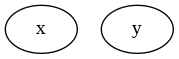

In [ ]:
from graphviz import Digraph
from IPython.display import Image as IPImage
from IPython.display import display_png

dg = Digraph(format='png')

dg.node('x')
dg.node('y')


display_png(IPImage(dg.render()))


#### 25.3 ノードの属性を指定する

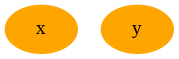

In [ ]:
dg = Digraph(format='png')

dg.node('x')

dg.node('x', color='orange', style='filled')
dg.node('y', color='orange', style='filled')

display_png(IPImage(dg.render()))

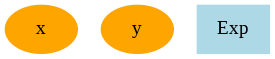

In [ ]:
dg = Digraph(format='png')

dg.node('x')

dg.node('x', color='orange', style='filled')
dg.node('y', color='orange', style='filled')
dg.node('Exp', color='lightblue', style='filled', shape='box')

display_png(IPImage(dg.render()))

#### 25.4 ノードを結ぶ

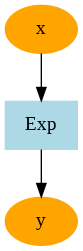

In [ ]:
dg = Digraph(format='png')

dg.node('x')

dg.node('x', color='orange', style='filled')
dg.node('y', color='orange', style='filled')
dg.node('Exp', color='lightblue', style='filled', shape='box')

dg.edge('x', 'Exp')
dg.edge('Exp', 'y')

display_png(IPImage(dg.render()))

### Step 26 計算グラフの可視化(2)

#### 25.1 可視化コードの使用例

最初に、このNotebook冒頭に記載してあるコマンドでdezeroをダウンロードします。

必要なライブラリとdezeroをインポートします。

In [ ]:
import numpy as np
from dezero import Variable
from dezero.utils import get_dot_graph

何らかの計算をして計算グラフを作成します。

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
print(txt)

digraph g {
140585104857296 [label="y", color=orange, style=filled]
140585586401352 [label="Add", color=lightblue, style=filled, shape=box]
140585107005680 -> 140585586401352
140585104857128 -> 140585586401352
140585586401352 -> 140585104857296
140585107005680 [label="x0", color=orange, style=filled]
140585104857128 [label="x1", color=orange, style=filled]
}


ファイルを保存します。

In [ ]:
with open('sample.dot', 'w') as o:
  o.write(txt)

In [ ]:
!dot sample.dot -T png -o sample.png

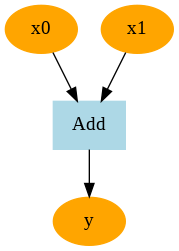

In [ ]:
display_png(IPImage('sample.png'))

#### 26.2 計算グラフからDOT言語への変換

In [ ]:
def _dot_var(v, verbose=False):
  dot_var = '{} [label="{}", color=orange, style=filled]\n'

  name = '' if v.name is None else v.name
  if verbose and v.data is not None:
    if v.name is not None:
      name += ': '
    name += str(v.shape) + ' ' + str(v.dtype)
  return dot_var.format(id(v), name)

In [ ]:
x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

NameError: ignored

In [ ]:
def _dot_func(f):
  dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
  txt = dot_func.format(id(f), f.__class__.__name__)

  dot_edge = '{} -> {}\n'
  for x in f.inputs:
    txt += dot_edge.format(id(x), id(f))
  for y in f.outputs:
    txt += dot_edge.format(id(f), id(y()))
  return txt

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))

y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

140585103368936 [label="Add", color=lightblue, style=filled, shape=box]
140585103095512 -> 140585103368936
140585103095568 -> 140585103368936
140585103368936 -> 140585103095456



In [ ]:
def get_dot_graph(output, verbose=True):
  txt = ''
  funcs = []
  seen_set = set()

  def add_func(f):
    if f not in seen_set:
      funcs.append(f)
      # funcs.sort(key=lambda x: x.generation)
      seen_set.add(f)

  add_func(output.creator)
  txt += _dot_var(output, verbose)

  while funcs:
    func = funcs.pop()
    txt += _dot_func(func)
    for x in func.inputs:
      txt += _dot_var(x, verbose)

      if x.creator is not None:
        add_func(x.creator)

  return 'digraph g {\n' + txt + '}'

#### 26.3 画像化までを含めた変換

In [ ]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
  dot_graph = get_dot_graph(output, verbose)

  tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')

  if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)
  graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

  with open(graph_path, 'w') as f:
    f.write(dot_graph)

  extension = os.path.splitext(to_file)[1][1:]
  cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
  subprocess.run(cmd, shell=True)

#### 26.4 動作確認

In [ ]:
import numpy as np
from dezero import Variable

def goldstein(x, y):
  z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
   (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'

plot_dot_graph(z, verbose=False, to_file='goldstein.png')

In [ ]:
!ls

dezero	examples  goldstein.png  LICENSE.md  README.md	setup.py  steps  tests


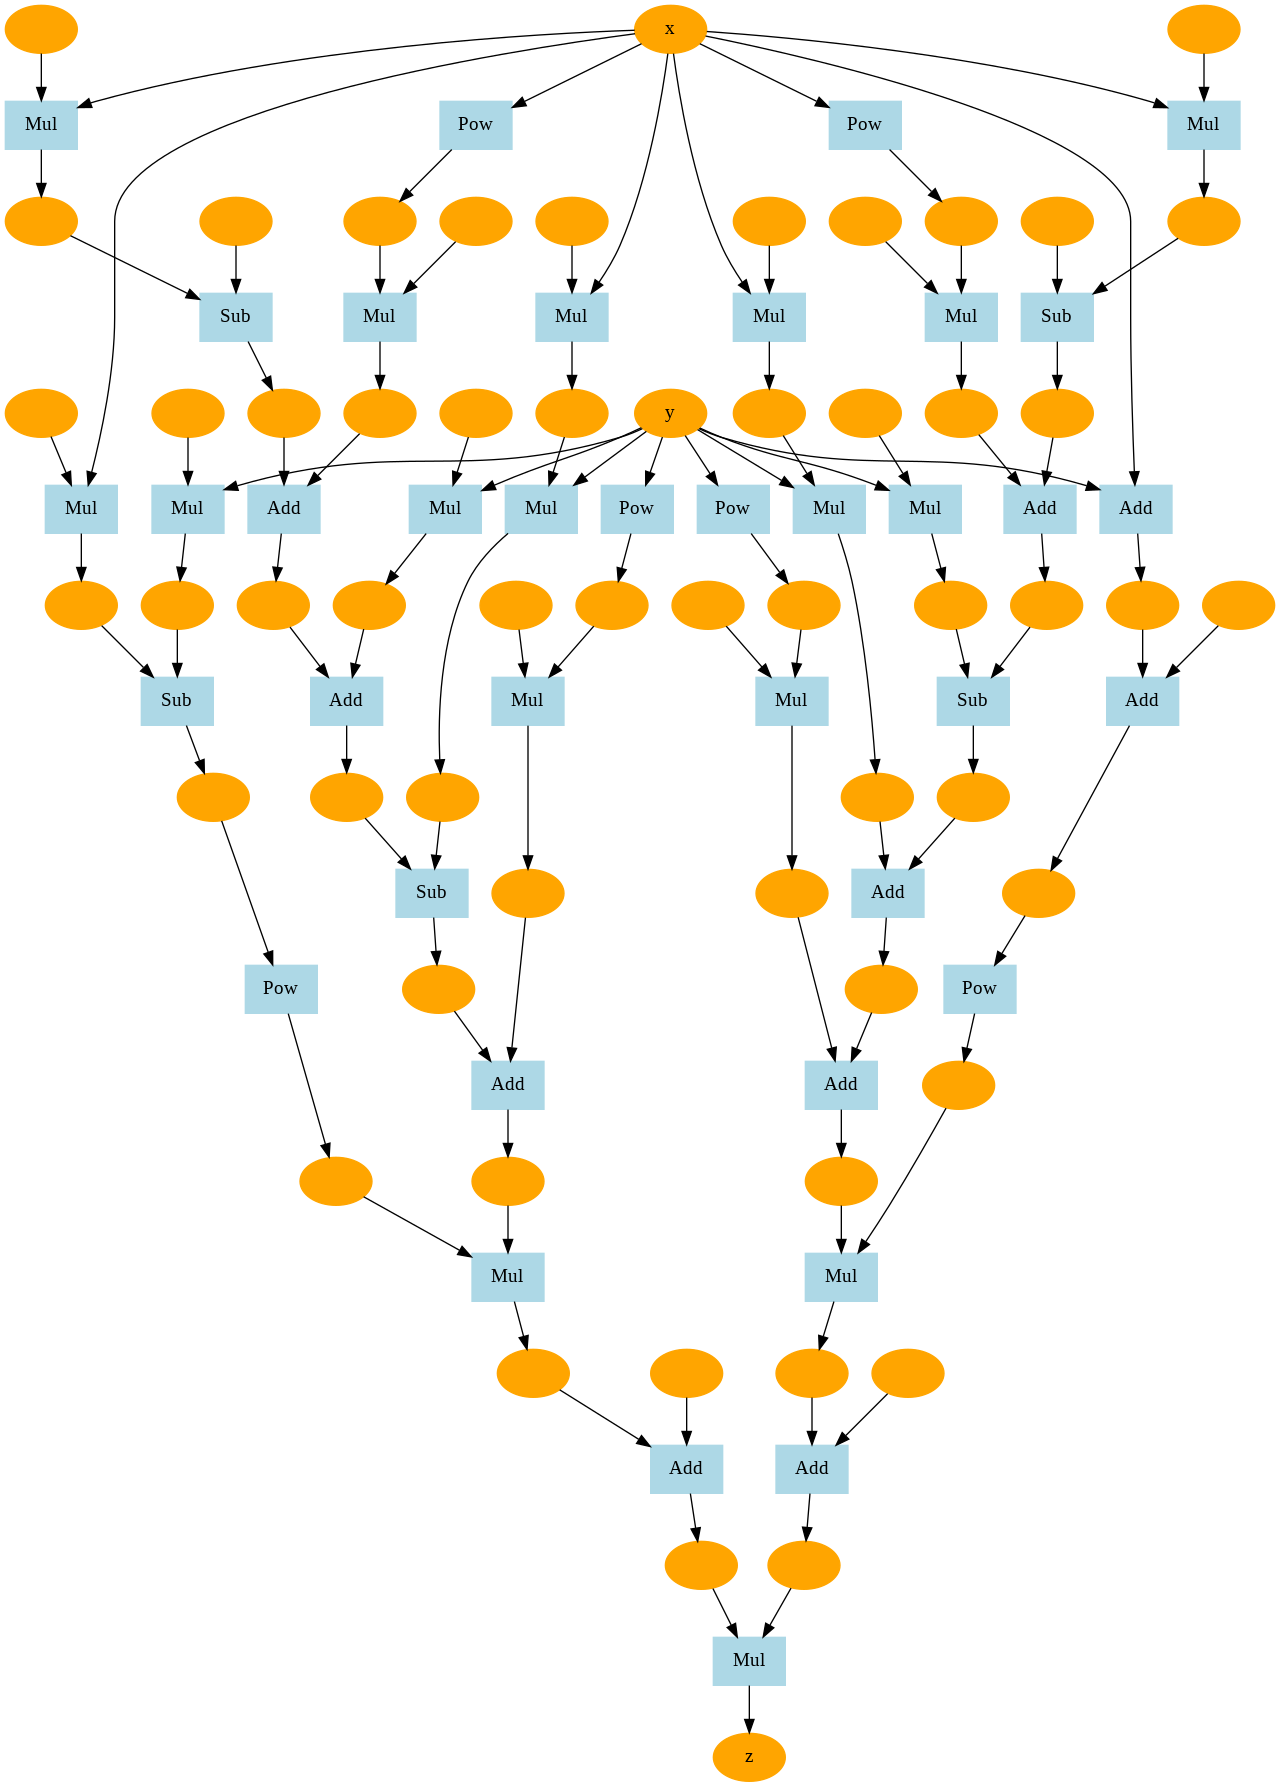

In [ ]:
display_png(IPImage('goldstein.png'))

### Step 27 テイラー展開の微分

#### 27.1 sin関数の実装

In [ ]:
import numpy as np
from dezero import Function

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx

def sin(x):
  return Sin()(x)

In [ ]:
from dezero import Variable

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


#### 27.2 テイラー展開の理論

テイラー展開

$f(x) = f(a) + f'(a)(x-a) + \frac{1}{2!}f''(a)(x-a)^2 + \frac{1}{3!}f'''(a)(x-a)^3 + \dots $

マクローリン展開（a=0のときのテイラー展開）

$f(x) = f(0) + f'(0)x + \frac{1}{2!}f''(0)x^2 + \frac{1}{3!}f'''(0)x^3 + \dots $

$f(x) = \sin(x)$ のマクローリン展開

$f'(x) = \cos(x), f''(x) = -\sin(x), f'''(x) = -\cos(x), f''''(x) = \sin(x), \dots$

$\sin(0) = 0, \cos(0) = 1$

$\sin(x) = \frac{x}{1!} - \frac{x^3}{3!} + \frac{x^5}{5!} - \dots$

In [ ]:
import math

def my_sin(x, threshold=0.0001):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2 * i + 1)
    t = c * x ** (2 * i + 1)
    y = y + t
    if abs(t.data) < threshold:
      break
  return y

In [ ]:
x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


#### 27.4 計算グラフの可視化

In [ ]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

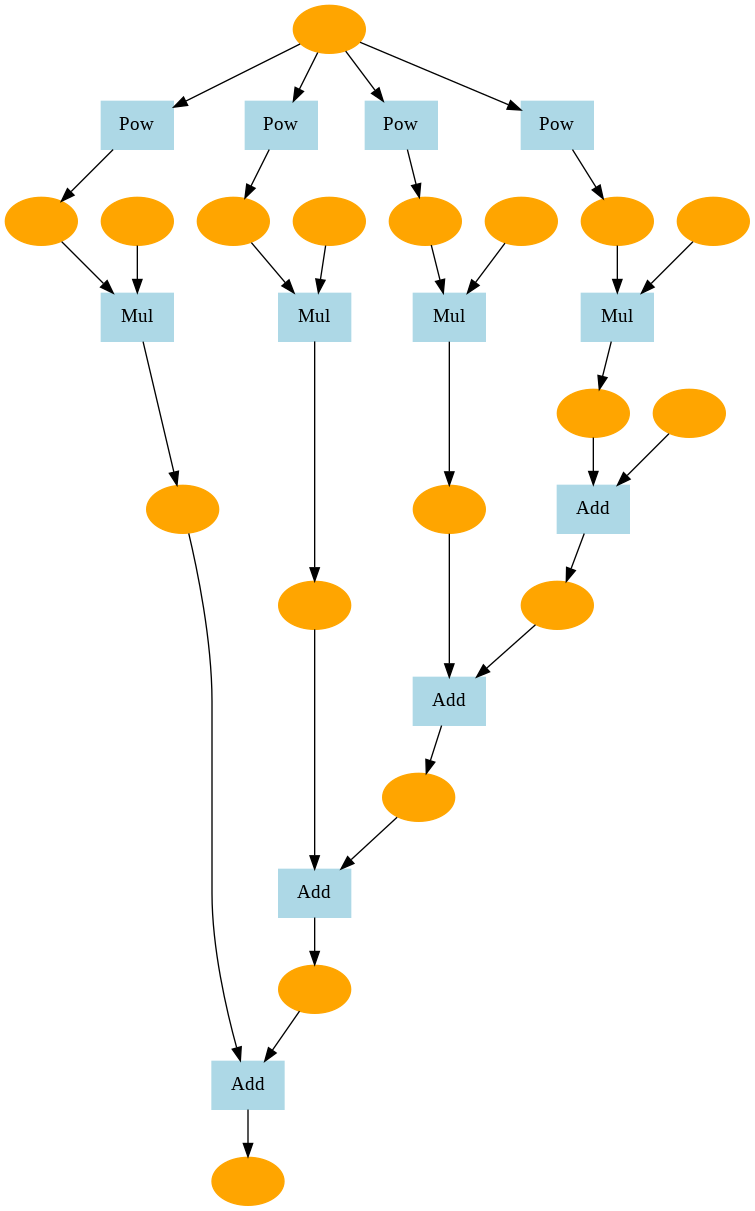

In [ ]:
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

In [ ]:
def my_sin(x, threshold=1e-150):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2 * i + 1)
    t = c * x ** (2 * i + 1)
    y = y + t
    if abs(t.data) < threshold:
      break
  return y

In [ ]:
x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
variable(0.7071067811865475)


In [ ]:
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

### Step 28 関数の最適化

#### 28.1 ローゼンブロック関数

$y = 100(x_1 - x_0^2)^2 + (x_0 -1)^2$

#### 28.2 微分を求める

In [ ]:
import numpy as np
from dezero import Variable

def rosenbrock(x0, x1):
  y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
  return y

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


#### 28.3 勾配降下法の実装

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
  print(x0, x1)

  y = rosenbrock(x0, x1)

  x0.cleargrad()
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

iters=10000にして再度計算します。

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 10000

for i in range(iters):
  print(x0, x1)

  y = rosenbrock(x0, x1)

  x0.cleargrad()
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

ストリーミング出力は最後の 5000 行に切り捨てられました。
variable(0.9570084124694905) variable(0.9156885683513011)
variable(0.9570268181468906) variable(0.9157238749885158)
variable(0.9570452153895911) variable(0.9157591661212849)
variable(0.9570636042019549) variable(0.9157944417570497)
variable(0.9570819845883425) variable(0.915829701903247)
variable(0.9571003565531113) variable(0.9158649465673097)
variable(0.9571187201006165) variable(0.9159001757566663)
variable(0.9571370752352101) variable(0.9159353894787414)
variable(0.9571554219612416) variable(0.9159705877409556)
variable(0.957173760283058) variable(0.916005770550725)
variable(0.9571920902050032) variable(0.9160409379154618)
variable(0.9572104117314186) variable(0.916076089842574)
variable(0.957228724866643) variable(0.9161112263394656)
variable(0.9572470296150123) variable(0.9161463474135364)
variable(0.95726532598086) variable(0.916181453072182)
variable(0.9572836139685166) variable(0.916216543322794)
variable(0.9573018935823099) variable(0.916251618

### Step 29 ニュートン法を用いた最適化（手計算）

#### 29.1 ニュートン法による最適化の理論

テイラー展開

$f(x) = f(a) + f'(a)(x-a) + \frac{1}{2!}f''(a)(x-a)^2 + \frac{1}{3!}f'''(a)(x-a)^3 + \dots $

　2階微分で打ち切ります。

$f(x) \simeq f(a) + f'(a)(x-a) + \frac{1}{2}f''(a)(x-a)^2$

　2次関数の最小値を解析的に求めます。微分が0の値を求めます。

$\frac{d}{dx}(f(x) \simeq f(a) + f'(a)(x-a) + \frac{1}{2}f''(a)(x-a)^2) = 0$

$f'(a) + \frac{1}{2}f''(a)(x - a) = 0$

$x = a - \frac{f'(a)}{f''(a)}$

$x \leftarrow x - \alpha f'(x)$

$x \leftarrow x - \frac{f'(x)}{f''(x)}$

ニュートン法は、勾配降下法のαを自動で調整します。ニュートン法は$\alpha = \frac{1}{f''(x)}$とした手法とみなすことができます。

物理のアナロジーで言えば、速度の情報だけを使うのが勾配降下法、速度と加速度の情報を使うのがニュートン法です。

#### 29.2 ニュートン法による最適化の実装

$y = x^4 - 2x^2$

$\frac{\partial y}{\partial x} = 4x^3 - 4x$


$\frac{\partial^2 y}{\partial x^2} = 12x^2 - 4$



In [ ]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

def gx2(x):
  return 12 * x ** 2 -4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward()

  x.data -= x.grad /gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 30 高階微分（準備編）

#### 30.1 確認作業1: Variableのインスタンス変数

ここはコードは実行せず、確認するだけです。

`__init__`メソッドだけを抜き出します。

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

#### 30.2 確認作業2: Functionクラス

`__call__`メソッドを確認します。

In [ ]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

Sinクラスのコードを確認します。

In [ ]:
class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx

In [ ]:
def sin(x):
  return Sin()(x)

x = Variable(np.array(1.0))
y = sin(x)

#### 30.3 確認作業3: Variableクラスの逆伝播

省略

### Step 31 高階微分（理論編）

#### 31.1 逆伝播で行う計算

コードの確認のみで実行はしません。

In [ ]:
class Sin(Function):
  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx

NameError: ignored

#### 31.2 逆伝播で計算グラフを作る方法

### Step 32 高階微分（実装編）

コードは単独では実行不可能な修正なので省略します。

これ以降は、DeZeroを`is_simple_core = False`にして実行します。

#### 32.1 新しいDeZeroへ

#### 32.2 関数クラスの逆伝播

#### 32.3 より効率的な逆伝播へ（モードの追加）

#### 32.4 `__init__.py`の変更

### Step 33 ニュートン法を使った最適化（自動計算）

#### 33.1 2階微分を求める

In [ ]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
gx.backward()
print(x.grad)

variable(24.0)
variable(68.0)


In [ ]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


#### 33.2 ニュートン法による最適化

$ x \leftarrow x - \frac{f'(x)}{f''(x)}$

In [ ]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 -2 * x ** 2
  return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)

  x.cleargrad()
  y.backward(create_graph=True)

  gx = x.grad
  x.cleargrad()
  gx.backward()
  gx2 = x.grad
  
  x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 34 sin関数の高階微分

#### 34.1 sin関数の実装

In [ ]:
import numpy as np
from dezero.core import Function

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * cos(x)
    return gx

def sin(x):
  return Sin()(x)

#### 34.2 cos関数の実装

In [ ]:
class Cos(Function):
  def forward(self, x):
    y = np.cos(x)
    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * -sin(x)
    return gx

def cos(x):
  return Cos()(x)

#### 34.3 sin関数の高階微分

In [ ]:
import numpy as np
from dezero.core import Variable
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)
  print(x.grad)

variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


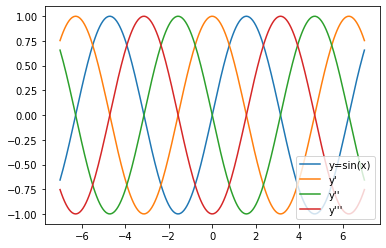

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7 , 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data.flatten()]

for i in range(3):
  logs.append(x.grad.data.flatten())
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
  plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

### Step 35 高階微分の計算グラフ

$\tanh$関数

$ y= \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

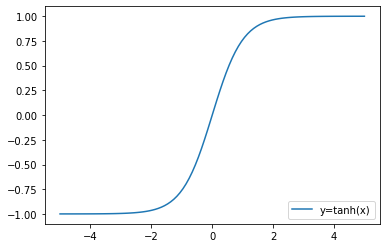

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
y = np.tanh(x)
plt.plot(x, y, label="y=tanh(x)")
plt.legend(loc='lower right')
plt.show()

#### 35.1 tanh関数の微分

微分の公式

$ (\frac{f(x)}{g(x)})' = \frac{f'(x)g(x) - f(x)g'(x)}{g(x)^2}$


$\begin{align} \frac{\partial \tanh(x)}{\partial x} & = \frac{(e^x + e^{-x})(e^x + e^{-x}) - (e^x - e^{-x})(e^x - e^{-x})}{(e^x + e^{-x})^2}\\
 &= 1 - y^2 \end{align}$

#### 35.2 tanh関数の実装

In [ ]:
class Tanh(Function):
  def forward(self, x):
    y = np.tanh(x)
    return y

  def backward(self, gy):
    x, = self.outputs[0]()
    gx = gy * (1 - y * y)
    return gx

def tanh(x):
  return Tanh()(x)

#### 35.3 高階微分の計算グラフの可視化

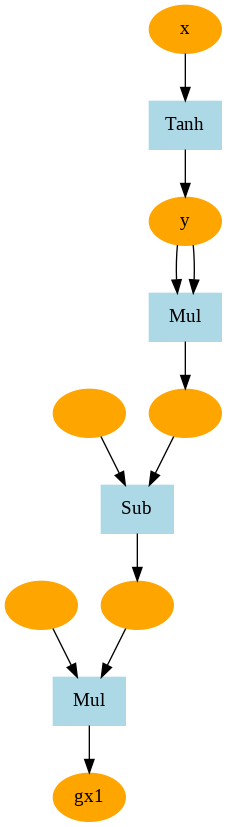

In [ ]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0

for i in range(iters):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

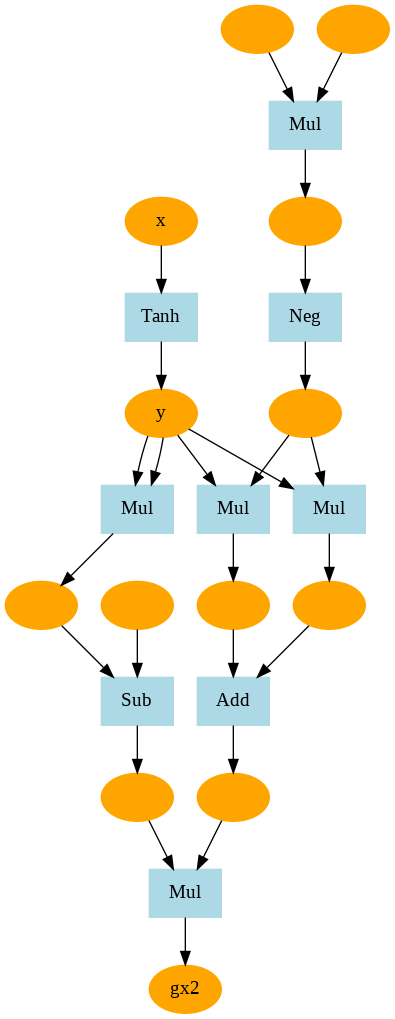

In [ ]:
iters = 1

for i in range(iters):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

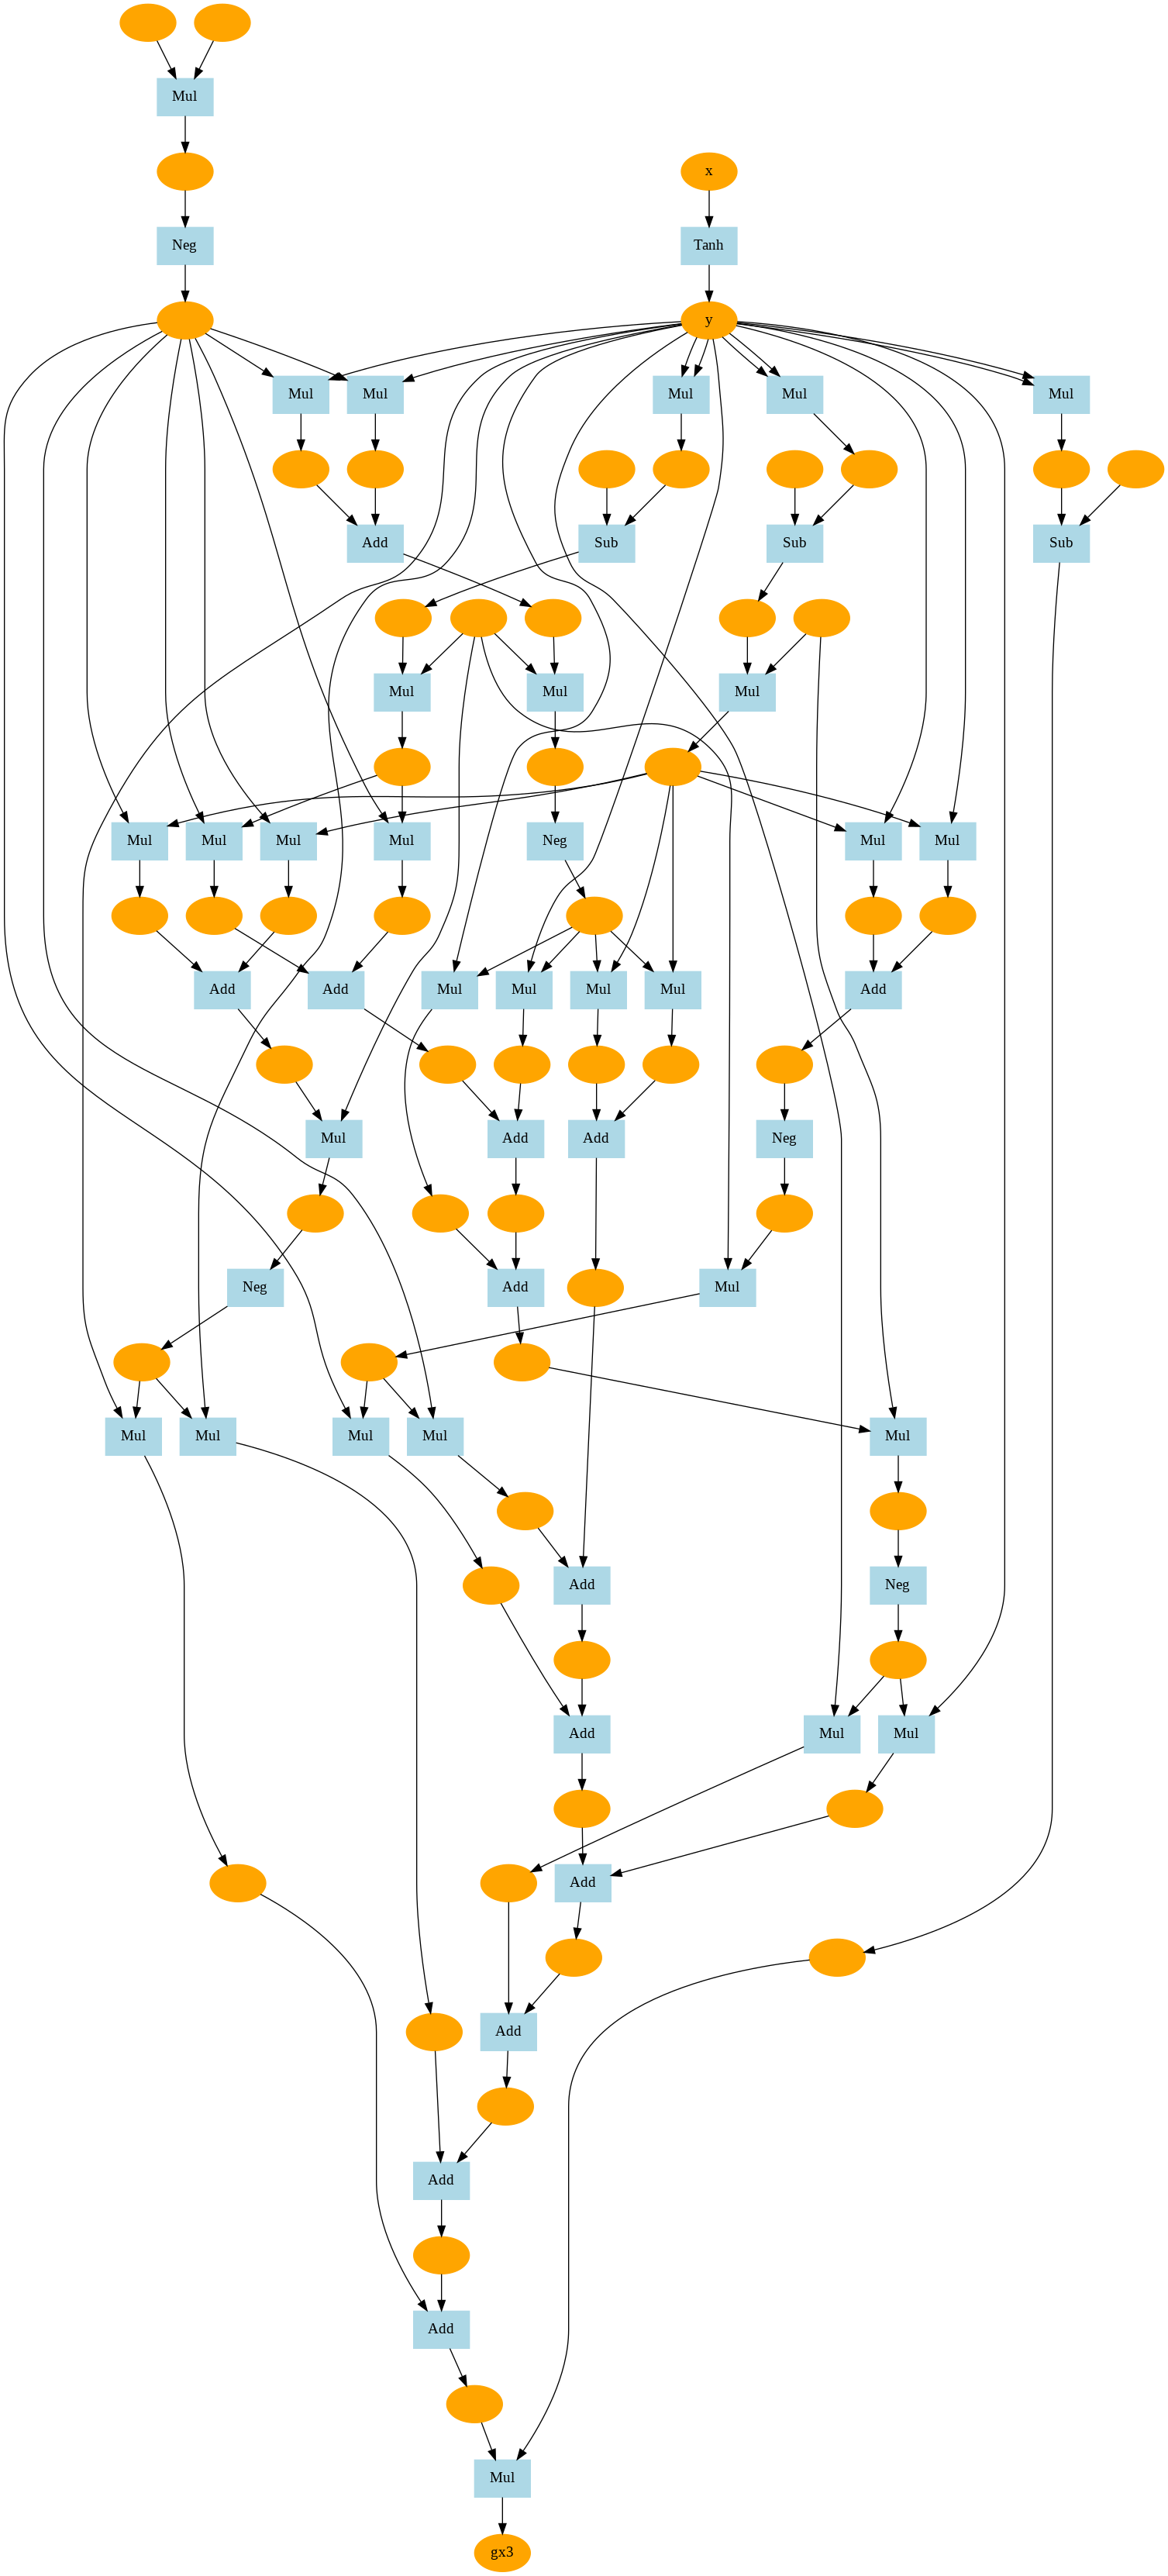

In [ ]:
iters = 2

for i in range(iters):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

### Step 36 高階微分以外の用途

#### 36.1 double backpropの用途

問：次の2つの式が与えられたとき、x=2.0における $\frac{\partial z}{\partial x}$を求めよ。

$y = x^2$

$z = (\frac{\partial z}{\partial x})^3 + y$

手計算で求めます。

$\begin{align}
\frac{\partial y}{\partial x} &= 2x\\
z &= (\frac{\partial z}{\partial x})^3 + y = 8x^3 + x^2\\
\frac{\partial z}{\partial x} & = 24 x^2 + 2x
\end{align}$

$24x^2 + 2x$に$x=2.0$を代入すると$100$です。

In [ ]:
import numpy as np
from dezero import Variable

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

variable(100.0)


#### 36.2 ディープラーニングでの研究での使用例

### コラム：ニュートン法とdouble backpropの補足

数式は割愛します。

ディープラーニングでは、ニュートン法は計算コストの問題（$n^2$オーダのメモリが必要）から、ほとんど使われません。

勾配だけを使った最適化が多く使用されます。

勾配のみ使用： SGD, Momentum, Adam...

準ニュートン法を使用： L-BFGS

L-BFGSはPyTorchで実装されています。

## Stage 4 ニューラルネットワークを作る

### Step 37 テンソルを扱う

#### 37.1 要素ごとの計算

In [ ]:
import numpy as np
import dezero.functions as F
from dezero import Variable

x = Variable(np.array(1.0))
y = F.sin(x)
print(y)

variable(0.8414709848078965)


In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

variable([[11 22 33]
          [44 55 66]])


#### 37.2 テンソルを使用したときのバックプロパゲーション

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)

In [ ]:
y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


#### 37.3 【補足】テンソルを使用したときのバックプロパゲーション

省略

### Step 38 形状を変える関数

#### 38.1 reshape関数の実装

In [ ]:
import numpy as np

x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.reshape(x, (6,))
print(y)

[1 2 3 4 5 6]


In [ ]:
from dezero import Function

class Reshape(Function):
  def __init__(self, shape):
    self.shape = shape
  
  def forward(self, x):
    self.x_shape = x.shape
    y = x.reshape(self.shape)
    return y

  def backward(self, gy):
    return reshape(gy, self.x_shape)

In [ ]:
from dezero.core import as_variable

def reshape(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return Reshape(shape)(x)

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


#### 38.2 Variableからreshapeを使う

In [ ]:
x = np.random.rand(1, 2, 3)

y = x.reshape((2, 3))
y = x.reshape([2, 3])
y = x.reshape(2, 3)

In [ ]:
x = Variable(np.random.randn(1, 2, 3))
y = x.reshape((2, 3))
y = x.reshape(2, 3)

variable([[ 1.19265994 -1.67575639  0.26012275]
          [-0.4589188   0.54006867  1.16963852]])
variable([[ 1.19265994 -1.67575639  0.26012275]
          [-0.4589188   0.54006867  1.16963852]])


In [ ]:
y

variable([[ 0.69195025 -1.76106779 -0.1354963 ]
          [-0.24232873  0.128402    1.2728545 ]])

#### 38.3 行列の転置

$
  x = \left(
    \begin{array}{ccc}
      x_{11} & x_{12} & x_{13} \\
      x_{21} & x_{22} & x_{23}
    \end{array}
  \right)
$

$
  x^T = \left(
    \begin{array}{ccc}
      x_{11} & x_{21} \\
      x_{12} & x_{22} \\
      x_{13} & x_{23}
    \end{array}
  \right)
$

In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.transpose(x)
print(y)

[[1 4]
 [2 5]
 [3 6]]


In [ ]:
class Transpose(Function):
  def forward(self, x):
    y = np.transpose(x)
    return y
  
  def backward(self, gy):
    gx = transpose(gy)
    return gx

def transpose(x):
  return Transpose()(x)

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [ ]:
x = Variable(np.random.rand(2, 3))
y = x.transpose()
y = x.T
print(y)

variable([[0.53752693 0.00546521]
          [0.49113577 0.53506653]
          [0.70958277 0.98596205]])


#### 38.4 【補足】実際のtranspose関数

In [ ]:
A, B, C, D = 1, 2, 3, 4
x = np.random.rand(A, B, C, D)
y = x.transpose(1, 0, 3, 2)
y

array([[[[0.47324384, 0.38728511, 0.41631163],
         [0.81578208, 0.12086764, 0.84196172],
         [0.27967365, 0.10077933, 0.35991132],
         [0.95165103, 0.11526225, 0.10685962]]],


       [[[0.03241745, 0.00339343, 0.54661107],
         [0.00123505, 0.80013661, 0.50286939],
         [0.93900234, 0.37694266, 0.15989403],
         [0.86667627, 0.34412407, 0.66885429]]]])

### Step 39 和を求める関数

#### 39.1 sum関数の逆伝播

足し算の微分は $y = x_0 + x_1$ のとき $\frac{\partial y}{\partial x_0} = 1 $, $\frac{\partial y}{\partial x_1} = 1$となります。

#### 39.2 sum関数の実装


In [ ]:
class Sum(Function):
  def forward(self, x):
    self.x_shape = x.shape
    y = y.sum()
    return y
  
  def backward(self, gy):
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum(x):
  return Sum()(x)

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([1 1 1 1 1 1])


In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([[1 1 1]
          [1 1 1]])


#### 39.3 axisとkeepdims

In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, ' -> ', y.shape)

[5 7 9]
(2, 3)  ->  (3,)


入力と出力を同じ次元数（軸の数）に保つかどうかを指定するフラグ keepdims

In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, keepdims=True)
print(y)
print(x.shape, ' -> ', y.shape)

[[21]]
(2, 3)  ->  (1, 1)


In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, keepdims=False)
print(y)
print(x.shape, ' -> ', y.shape)

21
(2, 3)  ->  ()


In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x)
print(y)
print(x.shape, ' -> ', y.shape)

21
(2, 3)  ->  ()


In [ ]:
from dezero import utils

class Sum(Function):
  def __init__(self, axis, keepdims):
    self.axis = axis
    self.keepdims = keepdims
  
  def forward(self, x):
    self.x_shape = x.shape
    y = x.sum(axis=self.axis, keepdims=self.keepdims)
    return y
  
  def backward(self, gy):
    gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum(x, axis=None, keepdims=False):
  return Sum(axis, keepdims)(x)

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


### Step 40 ブロードキャストを行う関数

#### 40.1 broadcast_to関数とsum_to関数

In [ ]:
import numpy as np

x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
print(y)

[[1 2 3]
 [1 2 3]]


In [ ]:
import numpy as np
from dezero.utils import sum_to

x = np.array([[1, 2, 3], [4, 5, 6]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


#### 40.2 DeZeroのbroadcast_toとsum_to関数

In [ ]:
class BroadcastTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    y = np.broadcast_to(x, self.shape)
    return y
  
  def backward(self, gy):
    gx = sum_to(gy, self.x_shape)
    return gx

def broadcast_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return BroadcastTo(shape)(x)

In [ ]:
from dezero import utils

class SumTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    y = utils.sum_to(x, self.shape)
    return y
  
  def backward(self, gy):
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return SumTo(shape)(x)

#### 40.3 ブロードキャストへの対応

In [ ]:
x0 = np.array([1,2,3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


In [ ]:
from dezero import Variable

x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [ ]:
from dezero import Function

class Add(Function):
  def forward(self, x0, x1):
    self,x0_shape, self.x1_shape = x0.shape, x1.shape
    y = x0 + x1
    return y

  def backward(self, gy):
    gx0, gx1 = gy, gy
    if self.x0_shape != self.x1_shape:
      gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
      gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
    return gx0, gx1

In [ ]:
import numpy as np
from dezero import Variable

x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([3])


### Step 41 行列の積

#### 41.1 ベクトルの内積と行列の積

$\boldsymbol{a} \boldsymbol{b} = a_1 b_1 + a_2 b_2 + \dots + a_n b_n$



$
  \left(
    \begin{array}{ccc}
      1 & 2 \\
      3 & 4
    \end{array}
  \right)
  \left(
    \begin{array}{ccc}
      5 & 6 \\
      7 & 8
    \end{array}
  \right)
   =
    \left(
    \begin{array}{ccc}
      19 & 22 \\
      43 & 50
    \end{array}
  \right)
$

内積と行列の積をNumpyで計算します。

本では`np.dot`を使っていますが、`@`で書く方法もあるので、そちらでも計算します。

他にも `np.matmul` `np.tensordot` などもあります。違いは以下記事が詳しいです。 `@`は`np.matmul`と同じです。

[テンソル同士の行列積を計算するにはnp.dot？np.matmul？np.tensordot？](https://blog.shikoan.com/tensor-product-in-numpy/)

In [ ]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.dot(a, b)
print(c)
c = a @ b
print(c)

a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print(c)
c = a @ b
print(c)

32
32
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]


#### 41.2 行列の形状チェック

行列の積の形状

##### 行列の積の逆伝播

$\boldsymbol{y}=\boldsymbol{xW}$

$\boldsymbol{x, W, y}$ の形状は$1 \times D, D \times H, 1 \times H$とします。

$x$の$i$番目の要素に対する微分 $\frac{\partial L}{\partial x_i}$は次のように求められます。

$\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j} \frac{\partial y_j}{\partial x_i}$


$\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j}W_{ij}$

$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} W^T$

形状は以下です。

$(1 \times D) (1 \times H) (H \times D)$

In [ ]:
from dezero import Function

class MatMul(Function):
  def forward(self, x, W):
    y = x.dot(W)
    return y

  def backward(self, gy):
    x, W = self.inputs
    gx = matmul(gy, W.T)
    gW = matmul(x.T, gy)
    return gx. gW

def matmul(x, W):
  return MatMul()(x, W)

In [ ]:
from dezero import Variable
import dezero.functions as F

x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


### Step 42 線形回帰

#### 42.1 トイ・データセット

In [ ]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 *x + np.random.rand(100, 1)

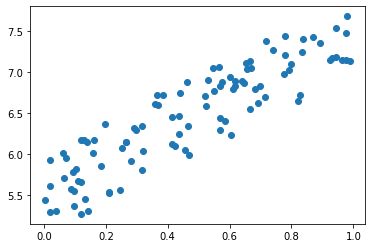

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

#### 42.2 線形回帰の理論

残差(residual)：データと予測値との差

平均2乗誤差(mean squared error)

$L = \frac{1}{N} \sum^N_{i=1}(f(x_i) - y_i)^2$

#### 42.3 線形回帰の実装

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
  y = F.matmul(x, W) + b
  return y

In [ ]:
def mean_squared_error(x0, x1):
  diff = x0 - x1
  return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
  y_pred = predict(x)
  loss = mean_squared_error(y, y_pred)

  W.cleargrad()
  b.cleargrad()
  loss.backward()

  W.data -= lr * W.grad.data
  b.data -= lr * b.grad.data
  print(W, b ,loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

In [ ]:
x = np.arange(0, 1, 0.02)
y_pred = W.data * x + b.data
y_true = 5.5 + 2 * x

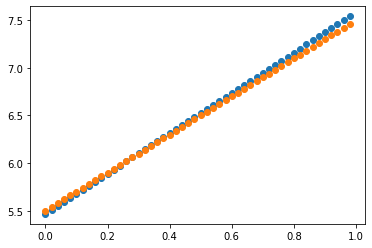

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y_pred)
plt.scatter(x, y_true)


#### 42.4 【補足】DeZeroのmean_squared_error関数

平均2乗誤差を求める関数のコードを抜粋します（実行は不要です）。

In [ ]:
def mean_squared_error(x0, x1):
  diff = x0 - x1
  y = F.sum(diff ** 2) / len(diff)
  return y

DeZeroの関数クラスの実装です（実行は不要です）

In [ ]:
from dezero import Function

class MeanSquaredError(Function):
  def forward(self, x0, x1):
    diff = x0 -x1
    y = (diff ** 2).sum() / len(diff)
    return y

  def backward(self, gy):
    x0, x1 = self.inputs
    diff = x0 - x1
    gy = broadcast_to(gy, diff.shape)
    gx0 = gy * diff * (2. / len(diff))
    gx1 = -gx0
    return gx0, gx1

def mean_squared_error(x0, x1):
  return MeanSquaredError()(x0, x1)

### Step 43 ニューラルネットワーク

#### 43.1 DeZeroのlinear関数

線形回帰で行った計算のコードの抜粋です（実行は不要です）

In [ ]:
y = F.matmul(x, W) + b

この変換は、線形変換(linear transformation)やアフィン変換(affine transformation)と呼ばれます。

注：線形変換は、厳密にはbは含みませんが、ニューラルネットワークの分野ではbまで含めて線形変換と呼ぶのが一般的とのことです。線形変換は、ニュールラルネットワークにおいては、全結合層に対応します。そして、パラメータのWは重み(weight)、パラメータのbはバイアス(bias)と呼ばれます。

linear_simple関数の実装です（実行は不要です）。

In [ ]:
def linear_simple(x, W, b=None):
  x, W = as_variable(x), as_variable(W)
  t = matmul(x, W)
  if b is None:
    return t

  y = t + b
  t.data = None
  return y

#### 43.2 非線形なデータセット

In [ ]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

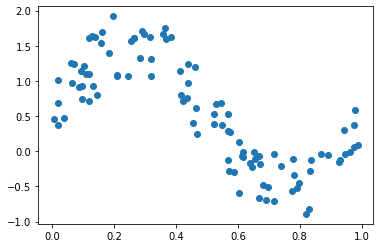

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

#### 43.3 活性化関数とニューラルネットワーク

シグモイド関数の式は以下です。

$ y = \frac{1}{1 + \exp (-x)}$

DeZeroでの実装です（以下は実行しません）。

In [ ]:
def sigmoid_simple(x):
  y = as_variable(x)
  y = 1 / (1 + exp(-x))
  return y

シグモイド関数の図をかきます。

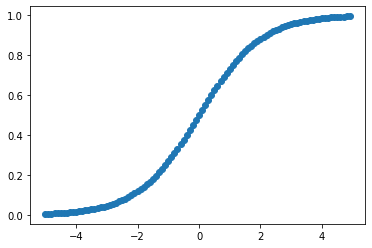

In [ ]:
x = np.arange(-5, 5, 0.1)
y = 1 / (1 + np.exp(-x))

import matplotlib.pyplot as plt
plt.scatter(x, y)

#### 43.4 ニューラルネットワークの実装

ニューラルネットワークの実装例です（パラメータの生成を省略しているので実行できません）。

In [ ]:
from dezero import Variable
import dezero.functions as F

W1, b1 = Variable(np.random.randn(...)), Variable(np.random.randn(...))
W2, b2 = Variable(np.random.randn(...)), Variable(np.random.randn(...))

def predict(x):
  y = F.linear(x, W1, b1)
  y = F.sigmoid(y)
  y = F.linear(y, W2, b2)
  return y

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x):
  y = F.linear(x, W1, b1)
  y = F.sigmoid(y)
  y = F.linear(y, W2, b2)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y, y_pred)

  W1.cleargrad()
  b1.cleargrad()
  W2.cleargrad()
  b2.cleargrad()
  loss.backward()

  W1.data -= lr * W1.grad.data
  b1.data -= lr * b1.grad.data
  W2.data -= lr * W2.grad.data
  b2.data -= lr * b2.grad.data
  if i % 1000 == 0:
    print(loss)

variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.24759485466749878)
variable(0.23786120447054837)
variable(0.21222231333102975)
variable(0.16742181117834257)
variable(0.0968193261999275)
variable(0.07849528290602342)
variable(0.07749729552991162)
variable(0.07722132399559321)


予測した曲線を可視化します。

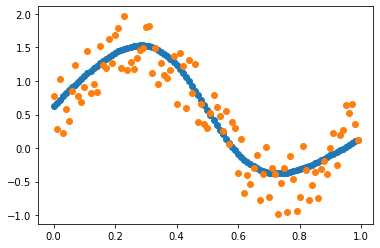

In [ ]:
x = np.arange(0, 1.0, 0.01).reshape(100, 1)
y_pred = predict(x)
y_true = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y_true)

### Stpe 44 パラメータをまとめるレイヤ

パラメータクラスは以下のような実装です（確認のみで、実行は不要です）。

In [ ]:
class Parameter(Variable):
  pass

ParameterインスタンスとVariableインスタンスは、組み合わせて計算することと、isinstance関数で区別することが可能です。

In [ ]:
import numpy as np
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


#### 44.2 Layerクラスの実装

In [ ]:
from dezero.core import Parameter

class Layer:
  def __init__(self):
    self._params = set()
  
  def __setattr__(self, name, value):
    if isinstance(value, Parameter):
      self._params.add(name)
    super().__setattr__(name, value)

In [ ]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('--------------')

for name in layer._params:
  print(name, layer.__dict__[name])

{'p1', 'p2'}
--------------
p1 variable(1)
p2 variable(2)


In [ ]:
from dezero.core import Parameter
import weakref

class Layer:
  def __init__(self):
    self._params = set()
  
  def __setattr__(self, name, value):
    if isinstance(value, Parameter):
      self._params.add(name)
    super().__setattr__(name, value)

  def __call__(self, *inputs):
    outputs = self.forward(*inputs)
    if not isinstance(outputs, tuple):
      outputs = (outputs,)
    self.inputs = [weakref.ref(x) for x in inputs]
    self.outputs = [weakref.ref(y) for y in outputs]
    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, inputs):
    raise NotImplementedError()

  def params(self):
    for name in self._params:
      yield self.__dict__[name]

  def cleargrads(self):
    for param in self.parames():
      param.cleargrad()

#### 44.3 Linearクラスの実装

Linearクラスの実装のコードです。

In [ ]:
import numpy as np
import dezero.functions as F
from dezero.core import Parameter

class Linear(Layer):
  def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
    super().__init__()

    I, O = in_size, out_size
    W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I)
    if nobias:
      self.b = None
    else:
      self.b = Parameter(np.zeros(0, dtype=dtype), name='b')

  def forward(self, x):
    y = F.linear(x, self.W, self.b)
    return y

Linearクラスのよりよい実装方式です。

In [ ]:
import numpy as np
import dezero.functions as F
from dezero.core import Parameter

class Linear(Layer):
  def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
    super().__init__()
    self.in_size = in_size
    self.out_size = out_size
    self.dtype = dtype

    self.W = Parameter(None, name='W')
    if self.in_size is not None:
      self._init_W()

    if nobias:
      self.b = None
    else:
      self.b = Parameter(np.zeros(out_size, dtype=dtype), name ='b')

  def _init_W(self):
    I, O = self.in_size, self.out_size
    W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
    self.W.data = W_data

  def forward(self, x):
    if self.W.data is None:
      self.in_size = x.shape[1]
      self._init_W()

    y = F.linear(x, self.W, self.b)
    return y

#### 44.4 Layerを使ったニューラルネットワークの実装

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F
import dezero.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
  y = l1(x)
  y = F.sigmoid(y)
  y = l2(y)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y, y_pred)

  l1.cleargrads()
  l2.cleargrads()
  loss.backward()

  for l in [l1, l2]:
    for p in l.params():
      p.data -= lr * p.grad.data

  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


学習した結果を可視化します。

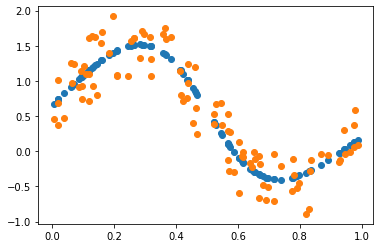

In [ ]:
y_pred = predict(x)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y)

### Step 45 レイヤをまとめるレイヤ

#### 45.1 Layerクラスの拡張

In [ ]:
from dezero.core import Parameter
import weakref

class Layer:
  def __init__(self):
    self._params = set()
  
  def __setattr__(self, name, value):
    if isinstance(value, (Parameter, Layer)):
      self._params.add(name)
    super().__setattr__(name, value)

  def params(self):
    for name in self._params:
      obj = self.__dict__[name]

      if isinstance(obj, Layer):
        yield from obj.params()
      else:
        yield obj

新しいLayerクラスを使ってニューラルネットワークを実装します。

In [ ]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def predict(model, x):
  y = model.l1(x)
  y = F.sigmoid(y)
  y = model.l2(y)
  return y

for p in model.params():
  print(p)

model.cleargrads()

variable([0. 0. 0.])
variable(None)
variable([0. 0. 0. 0. 0.])
variable(None)


#### 45.2 Modelクラス

Modelクラスの実装です（確認のみで実行不要です）。


In [ ]:
from dezero import Layer
from dezero import utils

class Model(Layer):
  def plot(self, *inputs, to_file='model.png'):
    y = self.forward(*inputs)
    return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

Modelクラスを使ったコードを書きます。

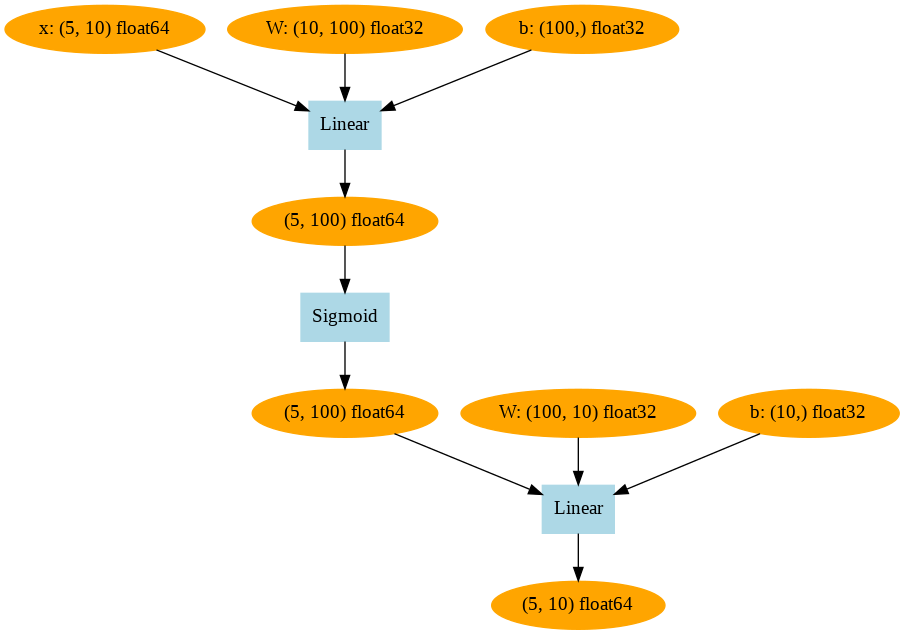

In [ ]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.l1 = L.Linear(hidden_size)
    self.l2 = L.Linear(out_size)

  def forward(self, x):
    y = F.sigmoid(self.l1(x))
    y = self.l2(y)
    return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

#### 45.3 Modelを使って問題を解く

In [ ]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

class TwoLayerNet(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.l1 = L.Linear(hidden_size)
    self.l2 = L.Linear(out_size)

  def forward(self, x):
    y = F.sigmoid(self.l1(x))
    y = self.l2(y)
    return y

model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)

  model.cleargrads()
  loss.backward()

  for p in model.params():
    p.data -= lr * p.grad.data
  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


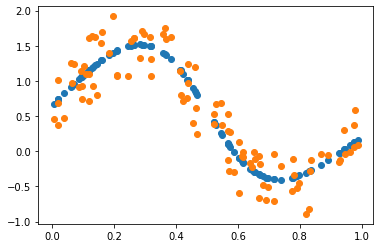

In [ ]:
y_pred = model(x)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y)

#### 45.4 MLPクラス

汎用的な全結合層のネットワークを実装します。

In [ ]:
import dezero.functions as F
import dezero.layers as L

class MLP(Model):
  def __init__(self, fc_output_sizes, activation=F.sigmoid):
    super().__init__()
    self.activation = activation
    self.layers = []

    for i, out_size in enumerate(fc_output_sizes):
      layer = L.Linear(out_size)
      setattr(self, 'l' + str(i), layer)
      self.layers.append(layer)

  def forward(self, x):
    for l in self.layers[:-1]:
      x = self.activation(l(x))
    return self.layers[-1](x)

MLPクラスを使って問題をときます。

In [ ]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

#model = MLP((10, 1))
model = MLP((10, 20, 30 ,40, 1))

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)

  model.cleargrads()
  loss.backward()

  for p in model.params():
    p.data -= lr * p.grad.data
  if i % 1000 == 0:
    print(loss)

variable(0.929483610152086)
variable(0.5520286081527978)
variable(0.5501279607594758)
variable(0.5327458383810609)
variable(0.23178449329460815)
variable(0.21062632550621843)
variable(0.17162561571879034)
variable(0.12208633739543633)
variable(0.09341503308559806)
variable(0.09873312135756641)


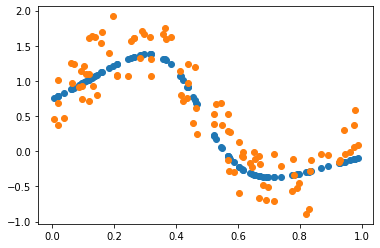

In [ ]:
y_pred = model(x)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y)

### Step 46 Optimizerによるパラメータ更新

#### 46.1 Optimizerクラス

In [ ]:
class Optimizer:
  def __init__(self):
    self.target = None
    self.hooks = []

  def setup(self, target):
    self.target = target
    return self

  def update(self):
    params = [p for p in self.target.params() if p.grad is not None]

    for f in self.hooks:
      f(params)

    for param in params:
      self.update_one(param)

  def update_one(self, param):
    raise NotImplementedError()

  def add_hook(self, f):
    self.hooks.append(f)

#### 46.2 SGDクラスの実装

In [ ]:
class SGD(Optimizer):
  def __init__(self, lr=0.01):
    super().__init__()
    self.lr = lr

  def update_one(self, param):
    param.data -= self.lr * param.grad.data

#### 46.3 SGDクラスを使って問題を解く

In [ ]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)

  model.cleargrads()
  loss.backward()

  optimizer.update()
  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


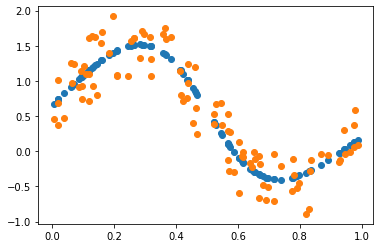

In [ ]:
y_pred = model(x)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y)

#### 46.4 SGD以外の最適化手法

Momentumの数式

$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}$

$ W \leftarrow W + v$


In [ ]:
import numpy as np

class MomentumSGD(Optimizer):
  def __init__(self, lr=0.01):
    super().__init__()
    self.lr = lr
    self.momentum = momentum
    self.vs = {}

  def update_one(self, param):
    v_key = id(param)
    if v_key not in self.vs:
      self.vs[v_key] = np.zeros_like(param.data)

    v = self.vs[v_key]
    v *= self.momentum
    v -= self.lr * param.grad.data
    param.data += v

Momentumを使って問題をときます。SGDをMomentumSGDに変更するだけです。

In [ ]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.MomentumSGD(lr)
optimizer.setup(model)

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)

  model.cleargrads()
  loss.backward()

  optimizer.update()
  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.07743134827996008)
variable(0.07544895146731471)
variable(0.07463260305858645)
variable(0.07420983776361516)
variable(0.07397000396385318)
variable(0.07383179319278561)
variable(0.07375198316276858)
variable(0.07370578149495666)
variable(0.0736788753834185)


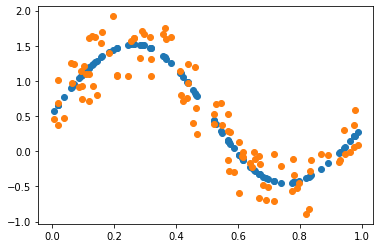

In [ ]:
y_pred = model(x)

import matplotlib.pyplot as plt
plt.scatter(x, y_pred.data)
plt.scatter(x, y)

### Step 47 ソフトマックス関数と交差エントロピー誤差

#### 47.1 スライス操作のための関数

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.get_item(x, 1)
print(y)

variable([4 5 6])


In [ ]:
y.backward()
print(x.grad)

variable([[0 0 0]
          [1 1 1]])


In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


In [ ]:
Variable.__getitem__ = F.get_item

y = x[1]
print(y)

y = x[:,2]
print(y)

variable([4 5 6])
variable([3 6])


#### 47.2 ソフトマックス関数

In [ ]:
from dezero.models import MLP

model = MLP((10, 3))

In [ ]:
x = np.array([[0.2, -0.4]])
y = model(x)
print(y)

variable([[ 1.13616723 -1.01599414  1.21082688]])


数値を確率に変換するのがソフトマックス関数です。

$p_k = \frac{\exp(y_k)}{\sum^n_{i=1} \exp(y_i)}$

ソフトマックス関数を実装します。

In [ ]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
  x = as_variable(x)
  y = F.exp(x)
  sum_y = F.sum(y)
  return y / sum_y

softmax1d関数を使います。

In [ ]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[ 1.13616723 -1.01599414  1.21082688]])
variable([[0.45584045 0.05298355 0.491176  ]])


pの各要素は 0以上1以下の値で、その和は1になります。

バッチデータに対してソフトマックス関数を適用できるようにソフトマックス関数を実装します。

In [ ]:
def softmax_simple(x, axis=1):
  x = as_variable(x)
  y = exp(x)
  sum_y = sum(y, axis=axis, keepdims=True)
  return y / sum_y

#### 47.3 交差エントロピー誤差

線形回帰では損失関数として平均2乗誤差を用いました。一方。多値分類を行うためには、一般的に交差エントロピー誤差が用いられます。次の式で定義されます。

$ L = - \sum_k t_k \log p_k$

$t_k$ は one-hotベクトルです。より簡略化して以下のようにも計算できます。

$ L = - \log p[t]$

交差エントロピー誤差の実装を行います。「ソフトマックス関数」と「交差エントロピー誤差」を合わせて行う関数を softmax_cross_entropy_simple(x, t) として実装します。


In [ ]:
def softmax_cross_entropy_simple(x, t):
  x, t = as_variable(x), as_variable(t)
  N = x.shape[0]

  p = softmax(x)
  p = clip(p, 1e-15, 1.0)
  log_p = log(p)
  tlog_p = log_p[np.arrange(N), t.data]
  y = -1 * sum(tlog_p) / N
  return y

clip関数に関しては、以下参照
- https://github.com/oreilly-japan/deep-learning-from-scratch-3/blob/master/dezero/functions.py

多値分類を行うニューラルネットワークに対して、具体的なデータを使って、交差エントロピー誤差を計算してみます。

In [ ]:
x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy_simple(y, t)
print(loss)

variable(1.534258844478294)


### Step 48 多値分類

#### 48.1 スパイラル・データセット

In [ ]:
import dezero

x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


#### 48.2 学習用のコード

多値分類を行うコードです。前半

In [ ]:
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

後半です。

In [ ]:
data_size = len(x)
max_iter = math.ceil(data_size / batch_size)
loss_history = []

for epoch in range(max_epoch):
  index = np.random.permutation(data_size)
  sum_loss = 0

  for i in range(max_iter):
    batch_index = index[i * batch_size:(i + 1) * batch_size]
    batch_x = x[batch_index]
    batch_t = t[batch_index]

    y = model(batch_x)
    loss = F.softmax_cross_entropy(y, batch_t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(batch_t)

  avg_loss = sum_loss / data_size
  loss_history.append(avg_loss)
  print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.08
epoch 2, loss 1.01
epoch 3, loss 0.94
epoch 4, loss 0.88
epoch 5, loss 0.90
epoch 6, loss 0.85
epoch 7, loss 0.79
epoch 8, loss 0.80
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.77
epoch 12, loss 0.78
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.78
epoch 16, loss 0.79
epoch 17, loss 0.75
epoch 18, loss 0.75
epoch 19, loss 0.73
epoch 20, loss 0.74
epoch 21, loss 0.75
epoch 22, loss 0.78
epoch 23, loss 0.74
epoch 24, loss 0.75
epoch 25, loss 0.75
epoch 26, loss 0.73
epoch 27, loss 0.73
epoch 28, loss 0.73
epoch 29, loss 0.74
epoch 30, loss 0.72
epoch 31, loss 0.73
epoch 32, loss 0.73
epoch 33, loss 0.72
epoch 34, loss 0.73
epoch 35, loss 0.72
epoch 36, loss 0.73
epoch 37, loss 0.72
epoch 38, loss 0.73
epoch 39, loss 0.72
epoch 40, loss 0.73
epoch 41, loss 0.71
epoch 42, loss 0.72
epoch 43, loss 0.71
epoch 44, loss 0.71
epoch 45, loss 0.71
epoch 46, loss 0.73
epoch 47, loss 0.72
epoch 48, loss 0.71
epoch 49, loss 0.72
epoch 50, loss 0.70
epoch 51,

学習の可視化をします。lossの減少する様子を表示します。

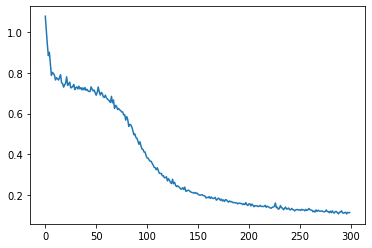

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

### Step 49 Datasetクラスと前処理

#### 49.1 Datasetクラスの実装

In [ ]:
import numpy as np

class Dataset:
  def __init__(self, train=True):
    self.train = train
    self.data = None
    self.label = None
    self.prepare()

  def __getitem__(self, index):
    assert np.isscalar(index)
    if self.label is None:
      return self.data[index], None
    else:
      return self.data[index], self.label[index]

  def __len__(self):
    return len(self.data)

  def prepare(self):
    pass

In [ ]:
class Spiral(Dataset):
  def prepare(self):
    self.data, self.label = get_spiral(self.train)

In [ ]:
import dezero

train_set = dezero.datasets.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


#### 49.2 大きいデータセットの場合

In [ ]:
class BigData(Dataset):
  def __getitem__(index):
    x = np.load('data/{}.npy'.format(index))
    t = np.load('label/{}.npy'.format(index))
    return x, t

  def __len__():
    return 1000000

#### 49.3 データの連結

In [ ]:
train_set = dezero.datasets.Spiral()

batch_index = [0, 1, 2]
batch = [train_set[i] for i in batch_index]
# batch = [(data_0, label_0), (data_1, label_1), (data_2, label_2)]

In [ ]:
x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


#### 49.4 学習用のコード

In [ ]:
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral() # ここを変更
model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)
loss_history = []

for epoch in range(max_epoch):
  index = np.random.permutation(data_size)
  sum_loss = 0

  for i in range(max_iter):
    batch_index = index[i * batch_size:(i + 1) * batch_size]
    batch = [train_set[i] for i in batch_index]
    batch_x = np.array([example[0] for example in batch]) # ここを変更
    batch_t = np.array([example[1] for example in batch]) # ここを変更

    y = model(batch_x)
    loss = F.softmax_cross_entropy(y, batch_t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(batch_t)

  avg_loss = sum_loss / data_size
  loss_history.append(avg_loss)
  print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.35
epoch 2, loss 1.06
epoch 3, loss 0.98
epoch 4, loss 0.90
epoch 5, loss 0.88
epoch 6, loss 0.84
epoch 7, loss 0.84
epoch 8, loss 0.81
epoch 9, loss 0.79
epoch 10, loss 0.77
epoch 11, loss 0.80
epoch 12, loss 0.77
epoch 13, loss 0.76
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.76
epoch 17, loss 0.76
epoch 18, loss 0.80
epoch 19, loss 0.78
epoch 20, loss 0.77
epoch 21, loss 0.76
epoch 22, loss 0.74
epoch 23, loss 0.79
epoch 24, loss 0.77
epoch 25, loss 0.75
epoch 26, loss 0.77
epoch 27, loss 0.77
epoch 28, loss 0.74
epoch 29, loss 0.77
epoch 30, loss 0.75
epoch 31, loss 0.75
epoch 32, loss 0.77
epoch 33, loss 0.74
epoch 34, loss 0.75
epoch 35, loss 0.76
epoch 36, loss 0.74
epoch 37, loss 0.80
epoch 38, loss 0.73
epoch 39, loss 0.74
epoch 40, loss 0.74
epoch 41, loss 0.78
epoch 42, loss 0.75
epoch 43, loss 0.72
epoch 44, loss 0.74
epoch 45, loss 0.71
epoch 46, loss 0.72
epoch 47, loss 0.74
epoch 48, loss 0.71
epoch 49, loss 0.71
epoch 50, loss 0.71
epoch 51,

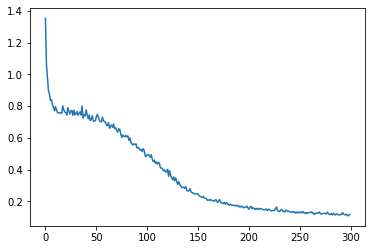

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

#### 49.5 データセットの前処理

In [ ]:
class Dataset:
  def __init__(self, train=True, transform=None, target_transform=None):
    self.train = train
    self.transform = target_transform
    self.target_transform = target_transform
    if self.transform is None:
      self.transform = lambda x: x
    if self.target_transform is None:
      self.target_transform = lambda x: x

    self.data = None
    self.label = None
    self.prepare()

  def __getitem__(self, index):
    assert np.isscalar(index)
    if self.label is None:
      return self.transform(self.data[index]), None
    else:
      return self.transform(self.data[index]), \
                self.target_transform(self.label[index])

  def __len__(self):
    return len(self.data)

  def prepare(self):
    pass

In [ ]:
def f(x):
  y = x / 2.0
  return y

train_set = dezero.datasets.Spiral(transform=f)

In [ ]:
print(train_set[0])
print(len(train_set))

(array([-0.06990694, -0.00360829], dtype=float32), 1)
300


In [ ]:
from dezero import transforms

f = transforms.Normalize(mean=0.0, std=2.0)
train_set = dezero.datasets.Spiral(transform=f)

In [ ]:
print(train_set[0])
print(len(train_set))

(array([-0.06990694, -0.00360829], dtype=float32), 1)
300


In [ ]:
f = transforms.Compose([transforms.Normalize(mean=0.0, std=2.0),
                                       transforms.AsType(np.float64)])

In [ ]:
train_set = dezero.datasets.Spiral(transform=f)
print(train_set[0])
print(len(train_set))

(array([-0.06990694, -0.00360829]), 1)
300


### Step 50 ミニバッチを取り出すDataLoader

#### 50.1 イテレータとは

In [ ]:
t = [1, 2, 3]
x = iter(t)

In [ ]:
next(x)

1

In [ ]:
next(x)

2

In [ ]:
next(x)

3

In [ ]:
next(x)

StopIteration: ignored

In [ ]:
class MyIterator:
  def __init__(self, max_cnt):
    self.max_cnt = max_cnt
    self.cnt = 0

  def __iter__(self):
    return self

  def __next__(self):
    if self.cnt == self.max_cnt:
      raise StopIteration()

    self.cnt += 1
    return self.cnt

In [ ]:
obj = MyIterator(5)
for x in obj:
  print(x)

1
2
3
4
5


In [ ]:
import math
import random
import numpy as np

class DataLoader:
  def __init__(self, dataset, batch_size, shuffle=True):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.data_size = len(dataset)
    self.max_iter = math.ceil(self.data_size / batch_size)

    self.reset()

  def reset(self):
    self.iteration = 0
    if self.shuffle:
      self.index = np.random.permutation(len(self.dataset))
    else:
      self.index = np.arrange(len(self.dataset))

  def __iter__(self):
    return self

  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()
      raise StopIteration

    i, batch_size = self.iteration, self.batch_size
    batch_index = self.index[i * batch_size:(i + 1) * batch_size]
    batch = [self.dataset[i] for i in batch_index]
    x = np.array([example[0] for example in batch])
    t = np.array([example[1] for example in batch])

    self.iteration += 1
    return x, t

  def next(self):
    return self.__next__()

#### 50.2 DataLoaderを使う

In [ ]:
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
  for x, t in train_loader:
    print(x.shape, t.shape)
    break
  for x, t in test_loader:
    print(x.shape, t.shape)
    break

(10, 2) (10,)
(10, 2) (10,)


#### 50.3 accuracy関数の実装

In [ ]:
def accuracy(y, t):
  y, t = as_variable(y), as_variable(t)

  pred = y.data.argmax(axis=1).reshape(t.shape)
  result = (pred == t.data)
  acc = result.mean()
  return Variable(as_array(acc))

In [ ]:
import numpy as np
import dezero.functions as F

y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

variable(0.6666666666666666)


#### 50.4 スパイラル・データセットの学習コード

In [ ]:
import dezero
from dezero.datasets import Spiral
from dezero import DataLoader
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

history_train_loss = []
history_train_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  history_train_loss.append(sum_loss / len(train_set))
  history_train_acc.append(sum_acc / len(train_set))

  print('epoch: {}'. format(epoch+1))
  print('train loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = F.accuracy(y, t)
      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  history_test_loss.append(sum_loss / len(test_set))
  history_test_acc.append(sum_acc / len(test_set))

  print('test loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(train_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.3072, accuracy: 0.3700
test loss: 1.0895, accuracy: 0.3933
epoch: 2
train loss: 1.0236, accuracy: 0.5500
test loss: 1.0265, accuracy: 0.5000
epoch: 3
train loss: 0.9277, accuracy: 0.5633
test loss: 0.9629, accuracy: 0.5500
epoch: 4
train loss: 0.9704, accuracy: 0.5000
test loss: 0.8582, accuracy: 0.5733
epoch: 5
train loss: 0.8939, accuracy: 0.5500
test loss: 0.8159, accuracy: 0.5133
epoch: 6
train loss: 0.8092, accuracy: 0.5600
test loss: 0.8175, accuracy: 0.5700
epoch: 7
train loss: 0.8119, accuracy: 0.5767
test loss: 0.7930, accuracy: 0.5433
epoch: 8
train loss: 0.8236, accuracy: 0.5567
test loss: 0.8149, accuracy: 0.5567
epoch: 9
train loss: 0.7926, accuracy: 0.6033
test loss: 0.7891, accuracy: 0.6067
epoch: 10
train loss: 0.7798, accuracy: 0.5533
test loss: 0.7841, accuracy: 0.5300
epoch: 11
train loss: 0.7706, accuracy: 0.5667
test loss: 0.7952, accuracy: 0.5567
epoch: 12
train loss: 0.7862, accuracy: 0.5700
test loss: 0.7684, accuracy: 0.5233
epoch: 13
tra

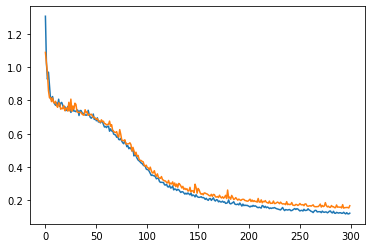

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_loss)
plt.plot(history_test_loss)

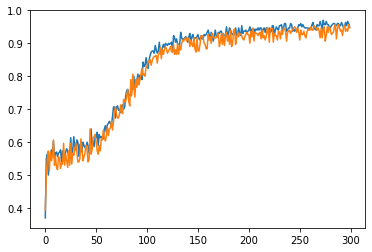

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_acc)
plt.plot(history_test_acc)

### Step 51 MNISTの学習

#### 51.1 MNISTデータセット

In [ ]:
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


In [ ]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


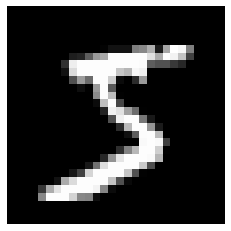

label: 5


In [ ]:
import matplotlib.pyplot as plt

x, t = train_set[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

In [ ]:
def f(x):
  x = x.flatten()
  x = x.astype(np.float32)
  x /= 255.0
  return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

In [ ]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (784,)
5


#### 51.2 MNISTの学習

In [ ]:
import dezero
from dezero import DataLoader
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

history_train_loss = []
history_train_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  history_train_loss.append(sum_loss / len(train_set))
  history_train_acc.append(sum_acc/ len(train_set))

  print('epoch: {}'. format(epoch+1))
  print('train loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = F.accuracy(y, t)
      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  history_test_loss.append(sum_loss/ len(test_set))
  history_test_acc.append(sum_acc / len(test_set))

  print('test loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9100, accuracy: 0.5588
test loss: 1.5282, accuracy: 0.7625
epoch: 2
train loss: 1.2758, accuracy: 0.7701
test loss: 1.0361, accuracy: 0.8119
epoch: 3
train loss: 0.9187, accuracy: 0.8182
test loss: 0.7903, accuracy: 0.8422
epoch: 4
train loss: 0.7361, accuracy: 0.8405
test loss: 0.6559, accuracy: 0.8539
epoch: 5
train loss: 0.6326, accuracy: 0.8540
test loss: 0.5751, accuracy: 0.8709


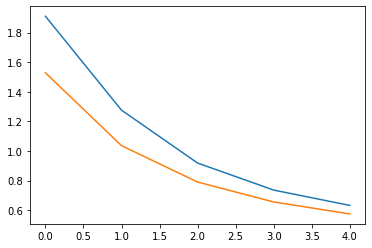

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_loss)
plt.plot(history_test_loss)

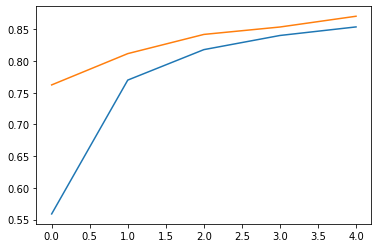

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_acc)
plt.plot(history_test_acc)

#### 51.3 モデルの改良

In [ ]:
from dezero import Function

class ReLU(Function):
  def forward(self, x):
    y = np.maximum(x, 0.0)
    return y

  def backward(self, gy):
    x, = self.inputs
    mask = x.data > 0
    gx = gy * mask
    return gx

def relu(x):
  return ReLU()(x)

In [ ]:
import dezero
from dezero import DataLoader
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, hidden_size, 10), activation=F.relu) # ReLUに変更
optimizer = optimizers.Adam().setup(model) # Adamに変更

history_train_loss = []
history_train_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  history_train_loss.append(sum_loss / len(train_set))
  history_train_acc.append(sum_acc / len(train_set))

  print('epoch: {}'. format(epoch+1))
  print('train loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = F.accuracy(y, t)
      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  history_test_loss.append(sum_loss/ len(test_set))
  history_test_acc.append(sum_acc / len(test_set))

  print('test loss: {:.4f}, accuracy: {:.4f}'.format(
      sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.1954, accuracy: 0.9399
test loss: 0.1168, accuracy: 0.9628
epoch: 2
train loss: 0.0743, accuracy: 0.9767
test loss: 0.0893, accuracy: 0.9730
epoch: 3
train loss: 0.0491, accuracy: 0.9846
test loss: 0.0736, accuracy: 0.9773
epoch: 4
train loss: 0.0348, accuracy: 0.9889
test loss: 0.0782, accuracy: 0.9782
epoch: 5
train loss: 0.0285, accuracy: 0.9906
test loss: 0.0809, accuracy: 0.9780


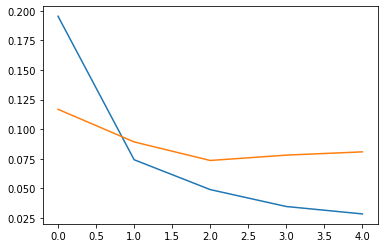

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_loss)
plt.plot(history_test_loss)

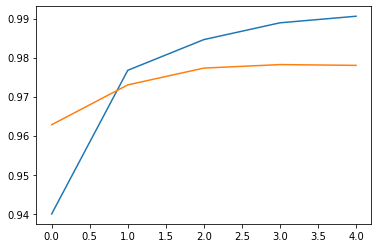

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train_acc)
plt.plot(history_test_acc)

## Stage 5 DeZeroで挑む

### Step 52 GPU対応

#### 52.1 CuPyのインストールと使用方法

In [ ]:
!pip install cupy

     |████████████████████████████████| 3.7MB 24.2MB/s 
  Created wheel for cupy: filename=cupy-7.4.0-cp36-cp36m-linux_x86_64.whl size=28644281 sha256=2ab7853d889e9ee57f3a3dd68fcf6059e5bee054b8836210cb358d99176a71e3
  Stored in directory: /root/.cache/pip/wheels/36/09/d1/35d25bee6e6dd451101b827d405befe1c2fb8522e671bc25ef
Successfully built cupy


In [ ]:
import cupy as cp

x = cp.arange(6).reshape(2, 3)
print(x)

y = x.sum(axis=1)
print(y)

[[0 1 2]
 [3 4 5]]
[ 3 12]


In [ ]:
import numpy as np
import cupy as cp

n = np.array([1, 2, 3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

c = cp.array([1, 2, 3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

In [ ]:
x = np.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == np

x = cp.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == cp

#### 52.2 cudaモジュール

In [ ]:
import numpy as np
gpu_enable = True
try:
  import cupy as cp
  cupy = cp
except ImportError:
  gpu_enable = False
from dezero import Variable

#### 52.3 Variable/Layer/DataLoaderクラスの追加実装

省略

#### 52.4 関数の追加実装

省略

#### 52.5 GPUでMNISTを学習

In [ ]:
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

if dezero.cuda.gpu_enable:
  print('gpu enable')
  train_loader.to_gpu()
  model.to_gpu()

history_train_loss = []

for epoch in range(max_epoch):
  start = time.time()
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)

  history_train_loss.append(sum_loss / len(train_set))

  elapsed_time = time.time() - start
  print('epoch: {}'. format(epoch+1))
  print('train loss: {:.4f}, time: {:.4f}[sec]'.format(
      sum_loss / len(train_set), elapsed_time))

gpu enable
epoch: 1
train loss: 1.9099, time: 4.0220[sec]
epoch: 2
train loss: 1.2748, time: 3.9195[sec]
epoch: 3
train loss: 0.9173, time: 3.8446[sec]
epoch: 4
train loss: 0.7342, time: 3.8236[sec]
epoch: 5
train loss: 0.6304, time: 3.9547[sec]


GPUを無効にして比較。

In [ ]:
dezero.cuda.gpu_enable = True

自分が試した時は以下

- GPU無し 9s程度
- GPU有り 4s程度


### Step 53 モデルの保存と読み込み

#### 53.1 Numpyのsave関数とload関数

In [ ]:
import numpy as np

x = np.array([1, 2, 3])
np.save('test.npy', x)

y = np.load('test.npy')
print(y)

[1 2 3]


複数のndarrayインスタンスの保存と読み込みについてです。

In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])

np.savez('test.npz', x1=x1, x2=x2)

arrays = np.load('test.npz')
z1 = arrays['x1']
z2 = arrays['x2']
print(z1)
print(z2)

[1 2 3]
[4 5 6]


ディクショナリを使ってかきます。

In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])
data = {'x1': x1, 'x2':x2}

np.savez('test.npz', **data)

arrays = np.load('test.npz')
z1 = arrays['x1']
z2 = arrays['x2']
print(z1)
print(z2)

[1 2 3]
[4 5 6]


np.savezと同じ働きをする関数に np.savez_compressed関数があります。ファイルサイズを圧縮して保存できます。

#### 53.2 Layerクラスのパラメータをフラットに

省略

#### 53.3 Layerクラスのsave関数とload関数

省略

### Step 54 Dropoutとテストモード

#### 54.1 Dropoutとは

Dropoutの学習時の処理のコードです。

In [ ]:
import numpy as np

dropout_ratio = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio
y = x * mask

In [ ]:
mask

array([False,  True,  True, False,  True, False, False, False, False,
        True])

In [ ]:
y

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])

Dropoutの学習時とテスト時の処理は以下です。

In [ ]:
# 学習時
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask
print(y)

# テスト時
scale = 1 - dropout_ratio
y = x * scale
print(y)

[0. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]


学習時は平均して40%のニューロンが生き残るので、テスト時にはすべてのニューロンを使って計算し、その出力を0.4倍することで学習時とテスト時のスケールを合わせます。

*x.shape に関してのメモ

In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]])
print(x.shape)
print(*x.shape)
print(x.shape[0])

(2, 3)
2 3
2


#### 54.2 Inverted Dropout

先ほど行ったテスト時のスケール合わせを、学習時に行うのがInverted Dropoutです。

コードは以下となります。

In [ ]:
# 学習時
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale
print(y)

# テスト時
y = x
print(y)

[2.5 0.  0.  2.5 0.  2.5 2.5 0.  0.  0. ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### 54.3 テストモードの追加

省略

#### 54.4 Dropoutの実装

In [ ]:
import numpy as np
from dezero import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

# 学習時
y = F.dropout(x)
print(y)

# テスト時
with test_mode():
  y = F.dropout(x)
  print(y)

[1. 1. 1. 1. 1.]
variable([0. 0. 0. 2. 2.])
variable([1. 1. 1. 1. 1.])


### Step 55 CNNのメカニズム(1)

#### 55.1 CNNのネットワーク構造

#### 55.2 畳み込み演算

省略

「フィルタ」と「カーネル」を同じ意味の用語として用います。

#### 55.3 パディング

省略

#### 55.4 ストライド

省略

#### 55.5 出力サイズの計算方法

In [ ]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
  return (input_size + pad * 2 - kernel_size) // stride + 1

In [ ]:
H, W = 4, 4 # input_shape
KH, KW = 3, 3 # kernel_shape
SH, SW = 1, 1 # stride
PH, PW = 1, 1 # padding

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


### Step 56 CNNのメカニズム(2)

#### 56.1 3階テンソル

省略

#### 56.2 ブロックで考える

省略

#### 56.3 ミニバッチ処理

省略

#### 56.4 プーリング層

プーリング層には以下の特徴があります。

- 学習するパラメータがない
- チャンネル数は変化しない
- 微小な位置変化に対してロバスト

### Step 57 conv2d関数とpooling関数

im2col = 「image to column」 「画像から列へ」

#### 57.1 im2colによる展開

省略

#### 57.2 conv2d関数の実装

In [ ]:
import numpy as np
import dezero.functions as F

x1 = np.random.rand(1, 3, 7, 7)
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


In [ ]:
def pair(x):
  if isinstance(x, int):
    return (x, x)
  elif isinstance(x, tuple):
    assert len(x) == 2
    return x
  else:
    raise ValueError

In [ ]:
#from dezero.utils import pair
print(pair(1))
print(pair((1, 2)))

(1, 1)
(1, 2)


In [ ]:
#from dezero.utils import pair, get_conv_outsize

def conv2d_simple(x, W, b=None, stride=1, pad=0):
  x, W = as_variable(x), as_variable(W)

  Weight = W
  N, C, H, W = x.shape
  OC, C, KH, KW = Weight.shape
  SH, SW = pair(stride)
  PH, PW = pair(pad)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, (KH, KW), stride, pad, to_matrix=True)
  Weight = Weight.reshape(OC, -1).transpose()
  t = linear(col, Weight, b)
  y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)
  return y

reshape関数の引数に -1 を指定すると、多次元配列の要素数の辻褄が合うように要素をまとめてくれます。

In [ ]:
x = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
print(x.reshape(-1))
print(x.reshape(-1, 2))
print(x.reshape(-1, 2).transpose())

[1 2 3 4 5 6 7 8]
[[1 2]
 [3 4]
 [5 6]
 [7 8]]
[[1 3 5 7]
 [2 4 6 8]]


In [ ]:
from dezero import Variable

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)

x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(y.shape)
print(x.grad.shape)

(1, 8, 15, 15)
(1, 5, 15, 15)


#### 57.3 Conv2d レイヤの実装

省略

#### 57.4 pooling関数の実装

In [ ]:
def pooling_simple(x, kernel_size, stride=1, pad=0):
  x = as_variable(x)

  N, C, H, W = x.shape
  KH, KW = pair(kernel_size)
  PH, PW = pair(pad)
  SH, SW = pair(stride)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, kernel_size, stride, pad, to_matrix=True)
  col = col.reshape(-1, KH * KW)
  y = col.max(axis=1)
  y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
  return y

In [ ]:
N, C, H, W = 1, 3, 4, 4
KH, KW = (2, 2)

x = Variable(np.random.randn(N, C, H, W))
y = F.pooling_simple(x, (KH, KW), stride=2, pad=0)
y.backward()

print(x.shape)
print(y.shape)
print(x.grad.shape)

(1, 3, 4, 4)
(1, 3, 2, 2)
(1, 3, 4, 4)


### Step 58 代表的なCNN(VGG16)

#### 58.1 VGG16の実装

VGG16の特徴は以下です。

- 3x3の畳み込み層を使う（パディングは 1x1）
- 畳み込み層のチャンネル数は、（基本的には）プーリングを行うと2倍になる(64->128->256->512)
- 全結合層ではDropoutを使う
- 活性化関数はReLUを使う

#### 58.2 学習済み重みデータ

Downloading: vgg16.npz
[##############################] 100.00% Done


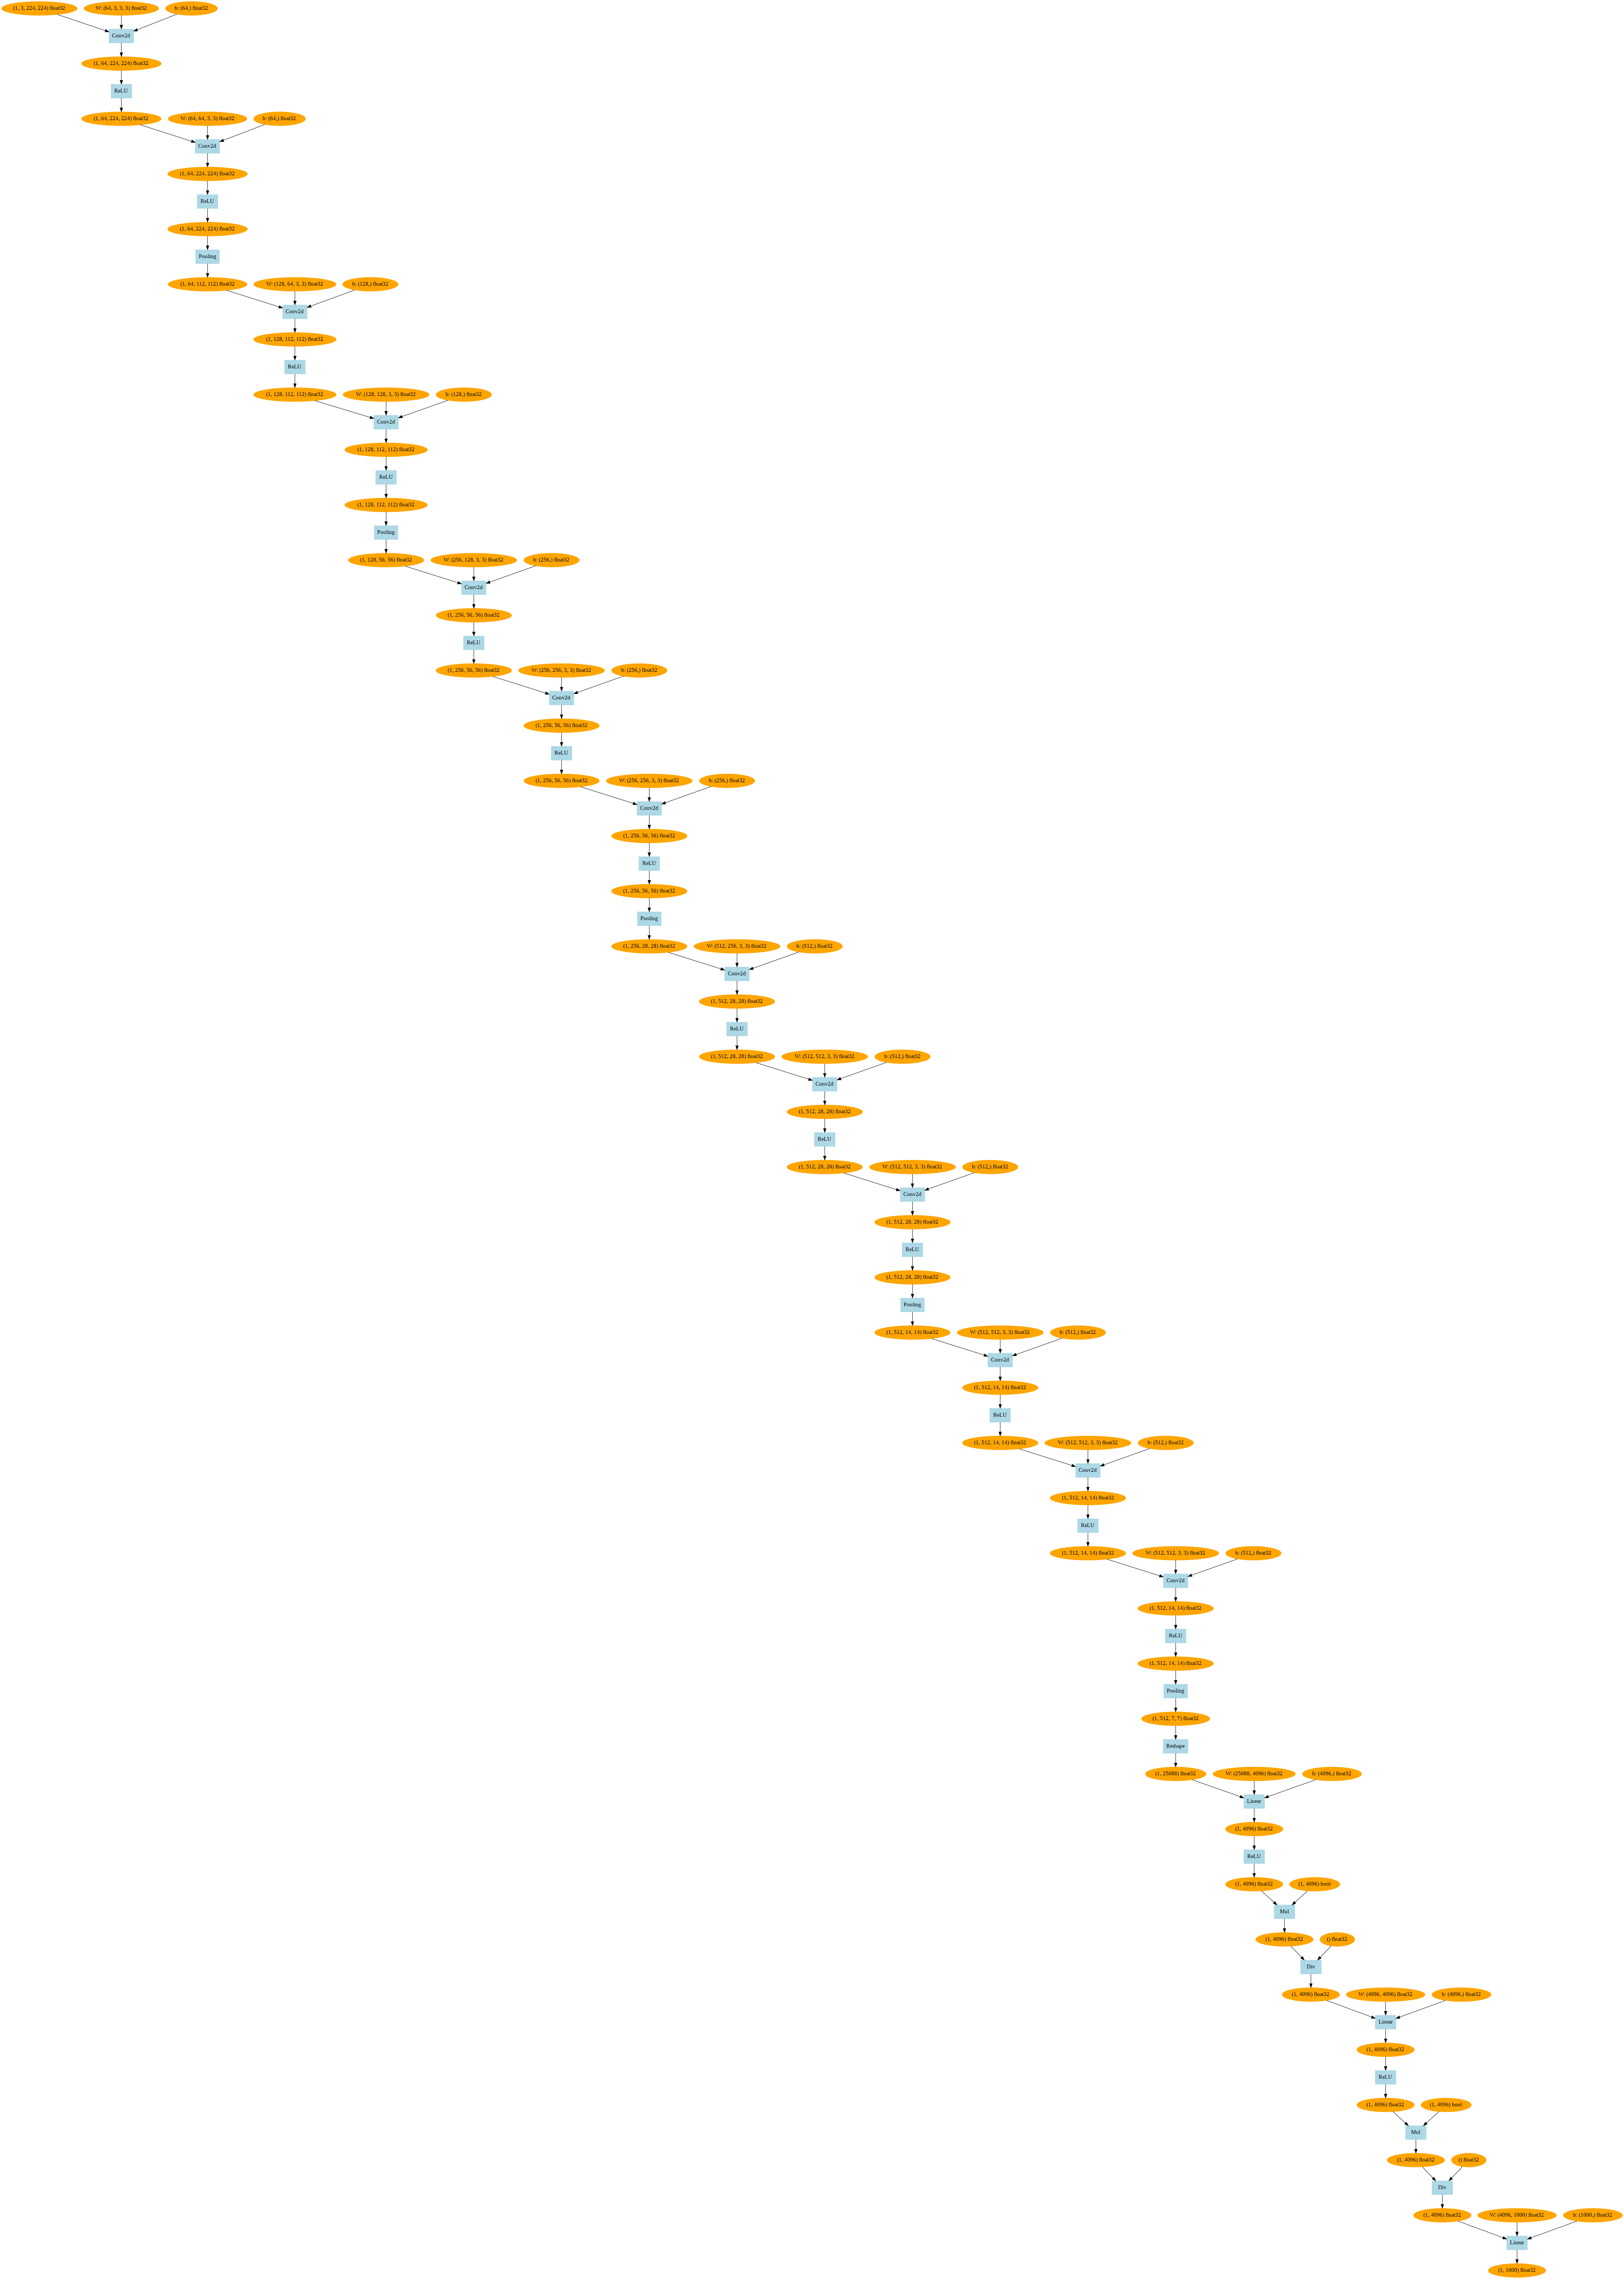

In [ ]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained=True)

x = np.random.randn(1, 3, 224, 224).astype(np.float32)
model.plot(x)

#### 58.3 学習済みのVGG16を使う

In [ ]:
import dezero
from PIL import Image
url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/' \
      'raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)

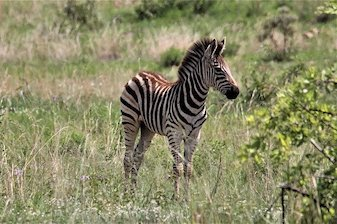

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display_jpeg

display_jpeg(IPImage(img_path))

In [ ]:
from dezero.models import VGG16

x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


本では `from models import VGG16`となっているが、おそらく誤植

In [ ]:
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16

url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/' \
      'raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)
x = VGG16.preprocess(img)
x = x[np.newaxis]

model = VGG16(pretrained=True)
with dezero.test_mode():
  y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = dezero.datasets.ImageNet.labels()
print(labels[predict_id])

Downloading: vgg16.npz
[##############################] 100.00% Done
Downloading: imagenet1000_clsidx_to_labels.txt
[##############################] 100.00% Done
zebra


### Step 59 RNNによる時系列データ処理

#### 59.1 RNNレイヤの実装

RNNの順伝播の数式は以下で表せられます。

$h_t = \tanh (h_{t-1} W_h + x_t W_x + b)$

- $W_x$: 入力$x$を隠れ層$h$に変換するための重み
- $W_h$: 1つ前のRNNの出力を次時刻の出力に変換するための重み
- b: バイアス

In [ ]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


#### 59.2 RNNモデルの実装

In [ ]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.RNN(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    h = self.rnn(x)
    y = self.fc(h)
    return y

In [ ]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:]

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
  y = model(x)
  loss += F.mean_squared_error(y, t)

  cnt += 1
  if cnt == 2:
    model.cleargrads()
    loss.backward()
    break

#### 59.3 「つながり」を切るためのメソッド

省略

#### 59.4 サイン波の予想

999
(array([-0.02768758]), array([-0.02584692]))
(array([-0.02584692]), array([0.02986285]))
(array([0.02986285]), array([0.06709731]))


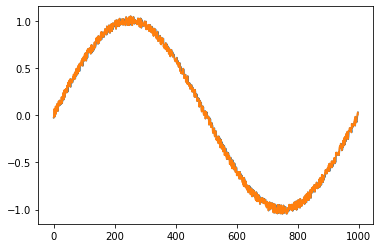

In [ ]:
import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

本では `ts = [example[0] for example in train_set]` となっているが、恐らく誤植

In [ ]:
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x, t in train_set:
    x = x.reshape(1, 1)
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1

    if count % bptt_length == 0 or count == seqlen:
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()
  
  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.346145
| epoch 2 | loss 0.048703
| epoch 3 | loss 0.027082
| epoch 4 | loss 0.005069
| epoch 5 | loss 0.003450
| epoch 6 | loss 0.002705
| epoch 7 | loss 0.002165
| epoch 8 | loss 0.002134
| epoch 9 | loss 0.002057
| epoch 10 | loss 0.002483
| epoch 11 | loss 0.003506
| epoch 12 | loss 0.005252
| epoch 13 | loss 0.005988
| epoch 14 | loss 0.004609
| epoch 15 | loss 0.003777
| epoch 16 | loss 0.004121
| epoch 17 | loss 0.004950
| epoch 18 | loss 0.005420
| epoch 19 | loss 0.005111
| epoch 20 | loss 0.004633
| epoch 21 | loss 0.004509
| epoch 22 | loss 0.004694
| epoch 23 | loss 0.004946
| epoch 24 | loss 0.005059
| epoch 25 | loss 0.004985
| epoch 26 | loss 0.004832
| epoch 27 | loss 0.004718
| epoch 28 | loss 0.004684
| epoch 29 | loss 0.004707
| epoch 30 | loss 0.004745
| epoch 31 | loss 0.004761
| epoch 32 | loss 0.004739
| epoch 33 | loss 0.004685
| epoch 34 | loss 0.004617
| epoch 35 | loss 0.004580
| epoch 36 | loss 0.004650
| epoch 37 | loss 0.004928
| epoch 38

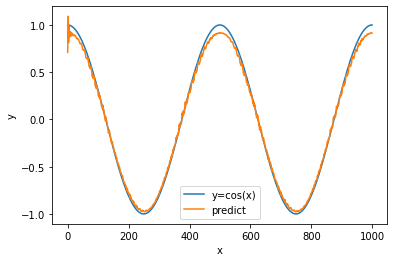

In [ ]:
import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1, 1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Step 60 LSTMとデータローダ

#### 60.1 時系列データのためのデータローダ

省略

#### 60.2 LSTMレイヤの実装

省略